In [71]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import collections
from collections import Counter
import wikipedia

import networkx as nx
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

from shapely import wkt
import geopandas as gpd
from shapely.geometry import Point, Polygon

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [ ]:
#scraping library of congress for list of local newspapers in USA
local_news = requests.get('https://www.loc.gov/rr/news/ncr_list.php')

soup = BeautifulSoup(local_news.text, "html.parser")
dfs = pd.read_html(local_news.text)

table = dfs[2].iloc[2:-1, 0:3]
table.columns = dfs[2].iloc[1, 0:3]

newspapers = pd.DataFrame(table).reset_index(drop=True)
print(len(newspapers))

In [ ]:
newspapers.head()

1    State        City                                              Title  \
0  Alabama  Birmingham                                    Birmingham News   
1  Alabama      Mobile                    Mobile Beacon & Alabama Citizen   
2  Alabama      Mobile  Mobile Register (Mobile Press Register on Sunday)   
3  Alabama  Montgomery                              Montgomery Advertiser   
4   Alaska   Anchorage  Anchorage daily news (continues Alaska dispatc...   

1                                    urls  
0          https://www.al.com/birmingham/  
1  https://www.techsoup.org/mobile-beacon  
2              https://www.al.com/mobile/  
3   https://www.montgomeryadvertiser.com/  
4                    https://www.adn.com/

Exploratory statistics on newspaper location

In [ ]:
newspapers.describe()

1          State      City  Title
count        417       417    417
unique        54       260    409
top     New York  New York  Times
freq          58        38      3

260


C:\Users\cgott\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0,0.5,'Number of Newspapers')

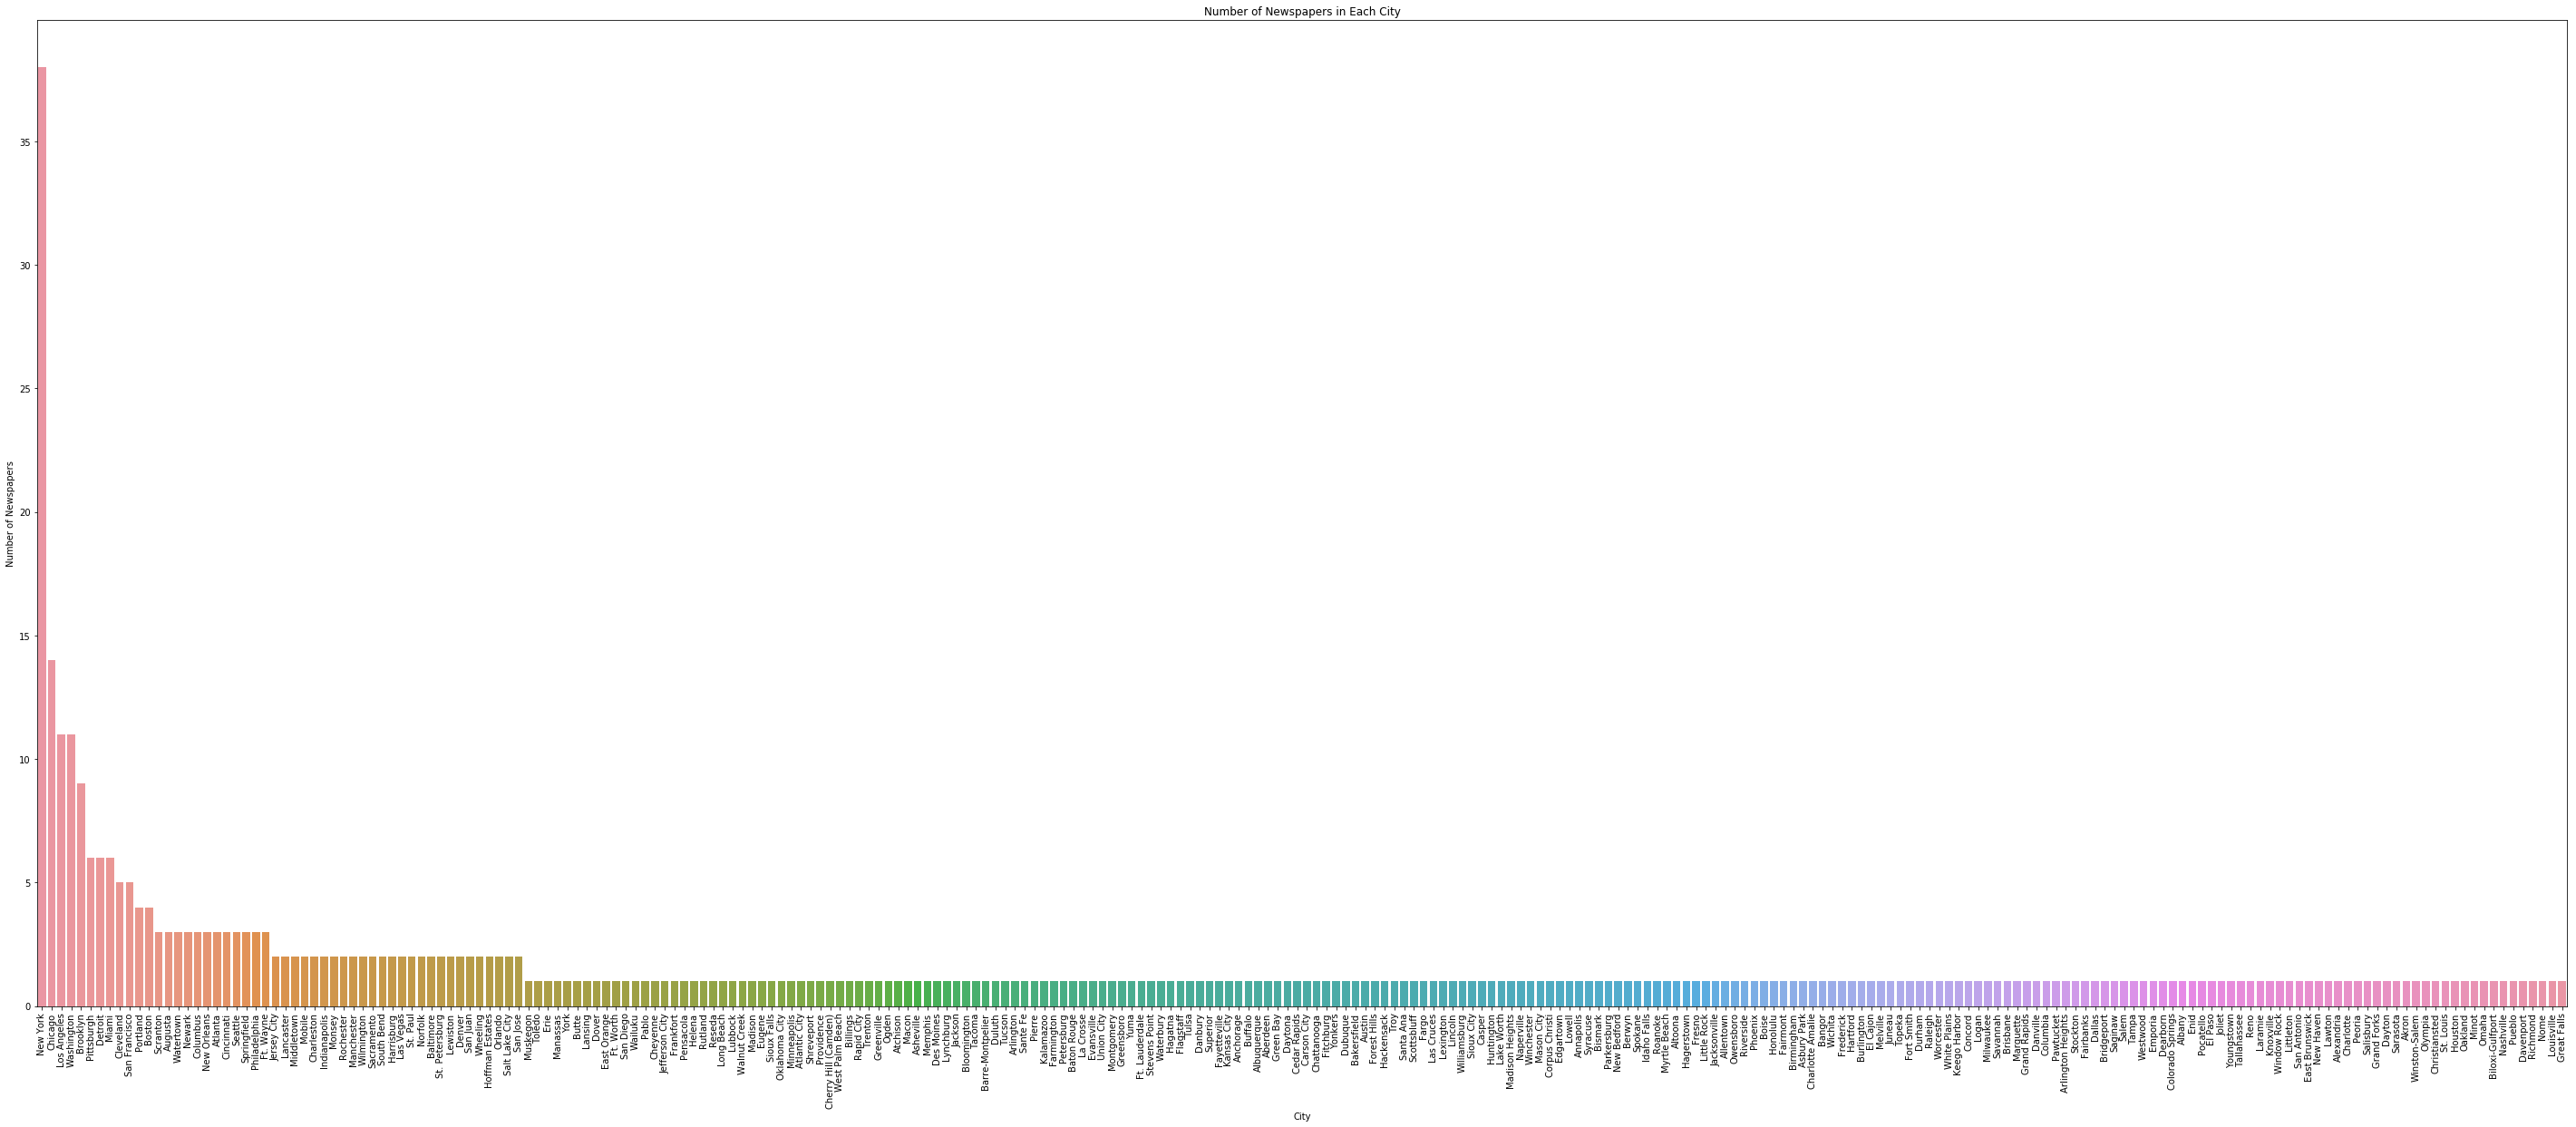

In [ ]:
#how many newspapers are there in every city
city_count = newspapers['City'].value_counts()
#how many cities are in the list
print(len(city_count))
#bar chart of the number of newspapers in each city
plt.figure(figsize=(50,20))
plot = sns.barplot(city_count.index, city_count.values)
plt.setp(plot.get_xticklabels(), rotation=90)
plt.title('Number of Newspapers in Each City')
plt.xlabel('City')
plt.ylabel('Number of Newspapers')

54


C:\Users\cgott\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0,0.5,'Number of Newspapers')

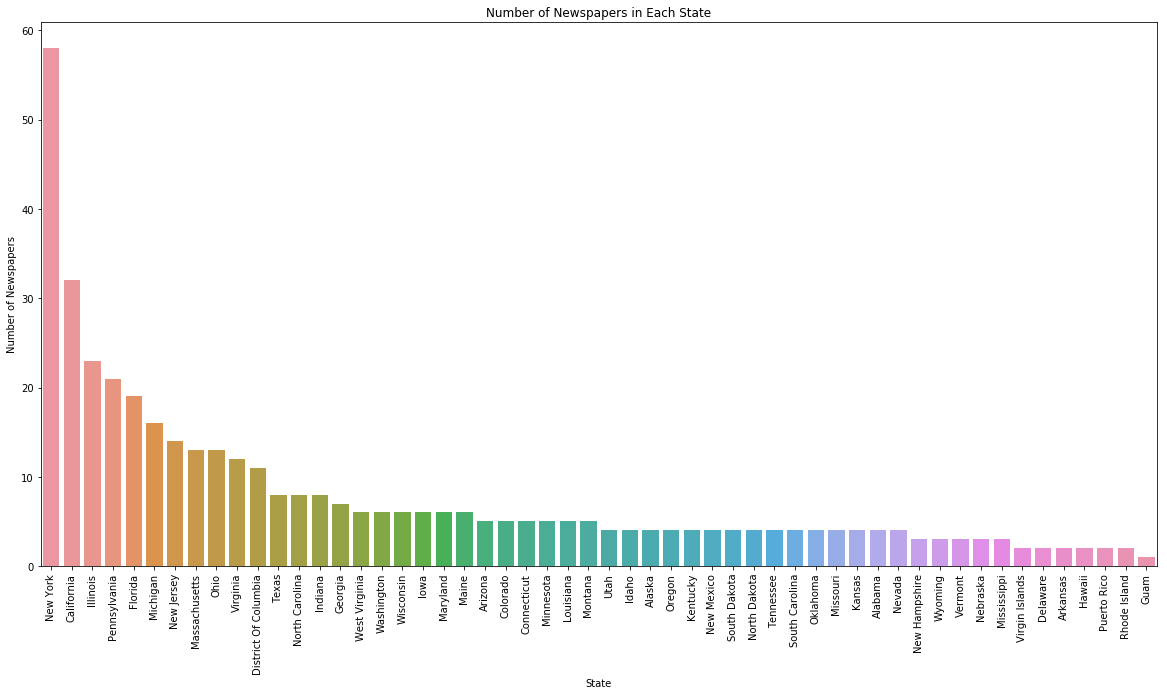

In [ ]:
#number of newspapers in every state
state_count = newspapers['State'].value_counts()
print(len(state_count))
#bar chart of the number of newspapers in each state
plt.figure(figsize=(20,10))
plot = sns.barplot(state_count.index, state_count.values)
plt.setp(plot.get_xticklabels(), rotation=90)
plt.title('Number of Newspapers in Each State')
plt.xlabel('State')
plt.ylabel('Number of Newspapers')

Gathering data on ownership and websites for each newspaper

In [ ]:
#searching wikipedia for the news papers websites and owners
newspapers['url'] =  np.nan
newspapers['owner'] =  np.nan

for i in range(len(newspapers)):
    try: #adding expection for no wikipedia page found, or no matching page
        #disregarding the newspapers where wikipedia page found is not actually a newspaper
        summary = wikipedia.summary(newspapers['City'][i] + ' ' + newspapers['Title'][i])
        matches = ["news", "News", "newspaper", "Newspaper"]
        if any(x in summary for x in matches):
            page = wikipedia.page(newspapers['City'][i] + ' ' + newspapers['Title'][i]).html()
            soup = BeautifulSoup(page)
            infobox_raw = soup.find('table', {'class': 'infobox'})
            #creating readable dictionary of the infobox
            infobox = {}

            try:# adding exception for those that have no infobox
                exceptional_row_count = 0
                for tr in infobox_raw.find_all('tr'):
                    if tr.find('th'):
                        infobox[tr.find('th').text] = tr.find('td').text
                    else:
                        # the first row Logos fall here
                        exceptional_row_count += 1

                if "Website" in infobox:
                    newspapers['url'][i] = infobox['Website']
                else:
                    newspapers['url'][i] = np.nan
                if "Owner(s)" in infobox:
                    newspapers['owner'][i] = infobox['Owner(s)']
                else: newspapers['owner'][i] = np.nan

            except AttributeError:
                newspapers['url'][i] = np.nan
        
    except (wikipedia.exceptions.PageError, wikipedia.exceptions.DisambiguationError): 
        newspapers['url'][i] = np.nan

C:\Users\cgott\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\cgott\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\cgott\Anaconda3\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\U

In [ ]:
newspapers.head()

1    State        City                                              Title  \
0  Alabama  Birmingham                                    Birmingham News   
1  Alabama      Mobile                    Mobile Beacon & Alabama Citizen   
2  Alabama      Mobile  Mobile Register (Mobile Press Register on Sunday)   
3  Alabama  Montgomery                              Montgomery Advertiser   
4   Alaska   Anchorage  Anchorage daily news (continues Alaska dispatc...   

1                 url                 owner  
0   al.com/birmingham  Advance Publications  
1                 NaN                   NaN  
2                 NaN                   NaN  
3                 NaN                   NaN  
4  http://www.adn.com           Binkley Co.

Exploratory stats with new data

In [ ]:
#removing the observations with nan values
newspapers_cut = newspapers.dropna().reset_index(drop=True)
print(len(newspapers_cut))
newspapers_cut.describe()

163


1          State      City  Title       url    owner
count        163       163    163       163      163
unique        49       135    156       157       79
top     New York  New York  Times  nola.com  Gannett
freq          14         8      3         2       33

In [ ]:
#noticed some discrepancies in the owner names, editing directly in the csv
'''newspapers_cut.to_csv('newspapers_cut.csv')'''
#added second owner column to the csv as some papers had two owners
#removed armenian newspaper from the list as it shut down in 2014
#removing duplicate papers (daily and sunday)
#adding websites that mistakenly gathered "official website" from wikipedia

In [ ]:
df = pd.read_csv('data/newspapers_cut.csv').reset_index(drop=True)
print(len(df))
df = df.drop(df.columns[0], axis=1)#removing the first column
print(df.head())
print(df.describe())


#correcting for repeated newspaper titles by adding city name in csv- cant have repeats for dictionary/network analysis
titles = collections.Counter(df.Title)
for i in range(len(titles)):
    if list(titles.values())[i] > 1:
        print(list(titles.keys())[i])


158
     State        City                       Title                 url  \
0  Alabama  Birmingham             Birmingham News   al.com/birmingham   
1   Alaska   Anchorage        Alaska dispatch news  http://www.adn.com   
2   Alaska   Fairbanks  Fairbanks Daily News-Miner       Newsminer.com   
3  Arizona   Flagstaff           Arizona Daily Sun      azdailysun.com   
4  Arizona      Tucson          Arizona Daily Star          tucson.com   

                        owner1 owner2  degree_centrality_o1  \
0         Advance Publications   None              0.034632   
1                  Binkley Co.   None              0.004329   
2  Helen E. Snedden Foundation   None              0.004329   
3              Lee Enterprises   None              0.069264   
4              Lee Enterprises   None              0.069264   

   degree_centrality_o2  degree_comp  
0                   NaN          NaN  
1                   NaN          NaN  
2                   NaN          NaN  
3               

In [ ]:
#creating dataframe of all the owners(1 and 2)
owners = []
paper = []
for i in range(len(df)):
    if df['owner1'][i] != 'None':
        owners.append(df['owner1'][i])
        paper.append(df['Title'][i])
    if df['owner2'][i] != 'None':
        owners.append(df['owner2'][i])
        paper.append(df['Title'][i])
print(len(set(owners)))#all unique owners
owner_zip = zip(paper, owners)
owner_df = pd.DataFrame(list(owner_zip), columns=['Title', 'owner'])

#newspapers_cut.to_csv('newspapers_cut.csv')

74


In [ ]:
owner_count = collections.Counter(owners)
owner_count = {k: v for k, v in sorted(owner_count.items(), key=lambda item: item[1], reverse=True)}#sorting the owners by the number of newspapers
#how many owners
print(len(owner_count))
ncount = len(owners)
#bar chart of the number of owners
plt.figure(figsize=(50,20))
plot = sns.barplot(np.array(list(owner_count.keys())), np.array(list(owner_count.values())))
plt.setp(plot.get_xticklabels(), rotation=90, fontsize=15)
plt.title('Number of Newspapers by Owner', fontsize=40)
plt.xlabel('Owner', fontsize=30)
plt.ylabel('Number of Newspapers', fontsize=30)

for p in plot.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    plot.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom', fontsize=15) # set the alignment of the text
            

plt.savefig('newspapers_by_owner.png')

135


/Users/cgottorff/Documents/ddgmtn/.env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


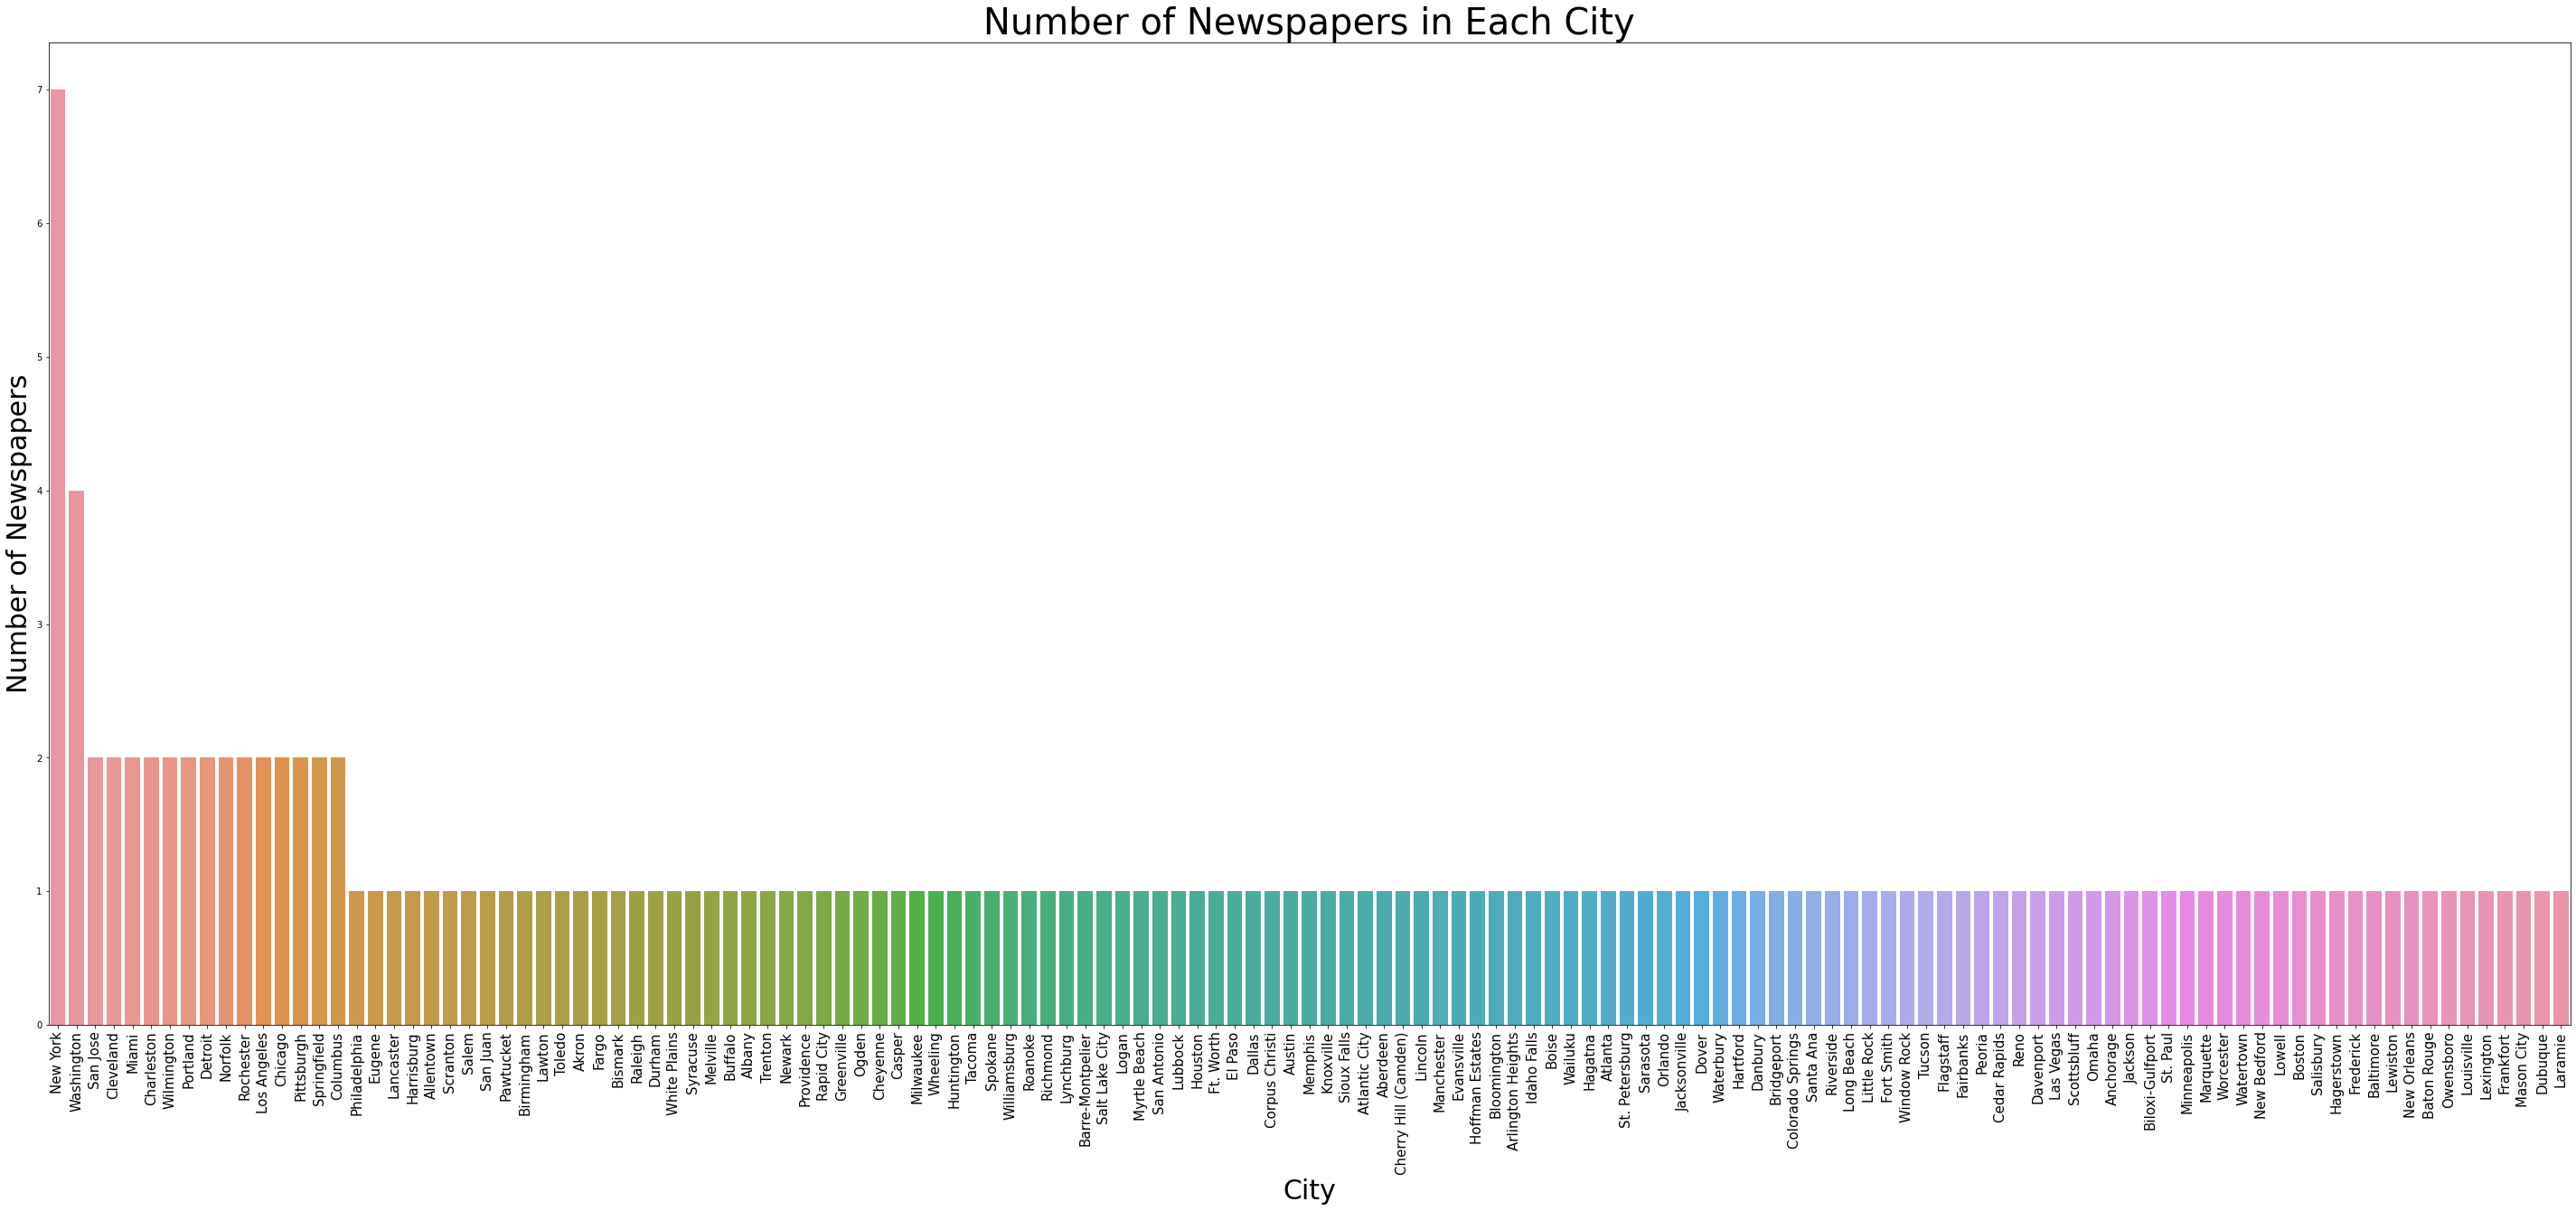

In [ ]:
#how many newspapers are there in every city
city_count = df['City'].value_counts()
#how many cities are in the list
print(len(city_count))
#bar chart of the number of newspapers in each city
plt.figure(figsize=(50,20))
plot = sns.barplot(city_count.index, city_count.values)
plt.setp(plot.get_xticklabels(), rotation=90, fontsize=15)
plt.title('Number of Newspapers in Each City', fontsize=40)
plt.xlabel('City', fontsize=30)
plt.ylabel('Number of Newspapers', fontsize=30)
plt.savefig('newspapers_per_city.pdf')

49


/Users/cgottorff/Documents/ddgmtn/.env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


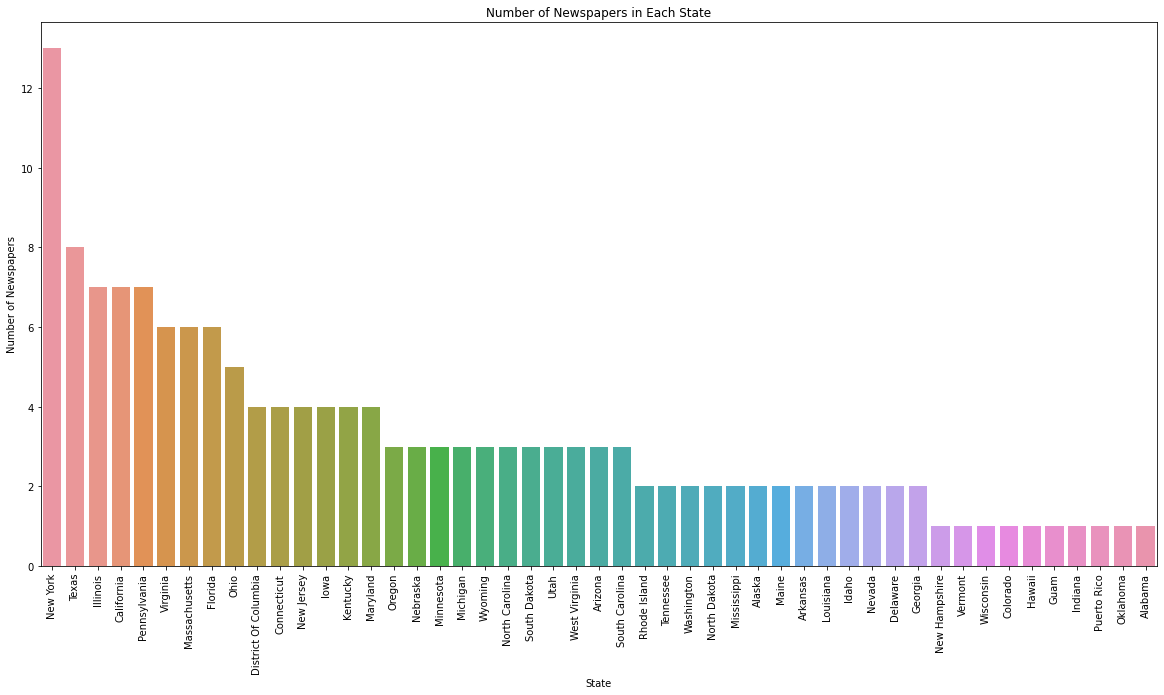

In [ ]:
#number of newspapers in every state
state_count = df['State'].value_counts()
print(len(state_count))
#bar chart of the number of newspapers in each state
plt.figure(figsize=(20,10))
plot = sns.barplot(state_count.index, state_count.values)
plt.setp(plot.get_xticklabels(), rotation=90)
plt.title('Number of Newspapers in Each State')
plt.xlabel('State')
plt.ylabel('Number of Newspapers')
plt.savefig('newspapers_per_state.pdf')

Network Analysis of Ownership


In [ ]:
G = nx.from_pandas_edgelist(owner_df,
                            source='owner',
                            target='Title')
print(G.is_directed()) #making sure undirected graph since edges are bidirectional
                        

False


Graph with 232 nodes and 169 edges


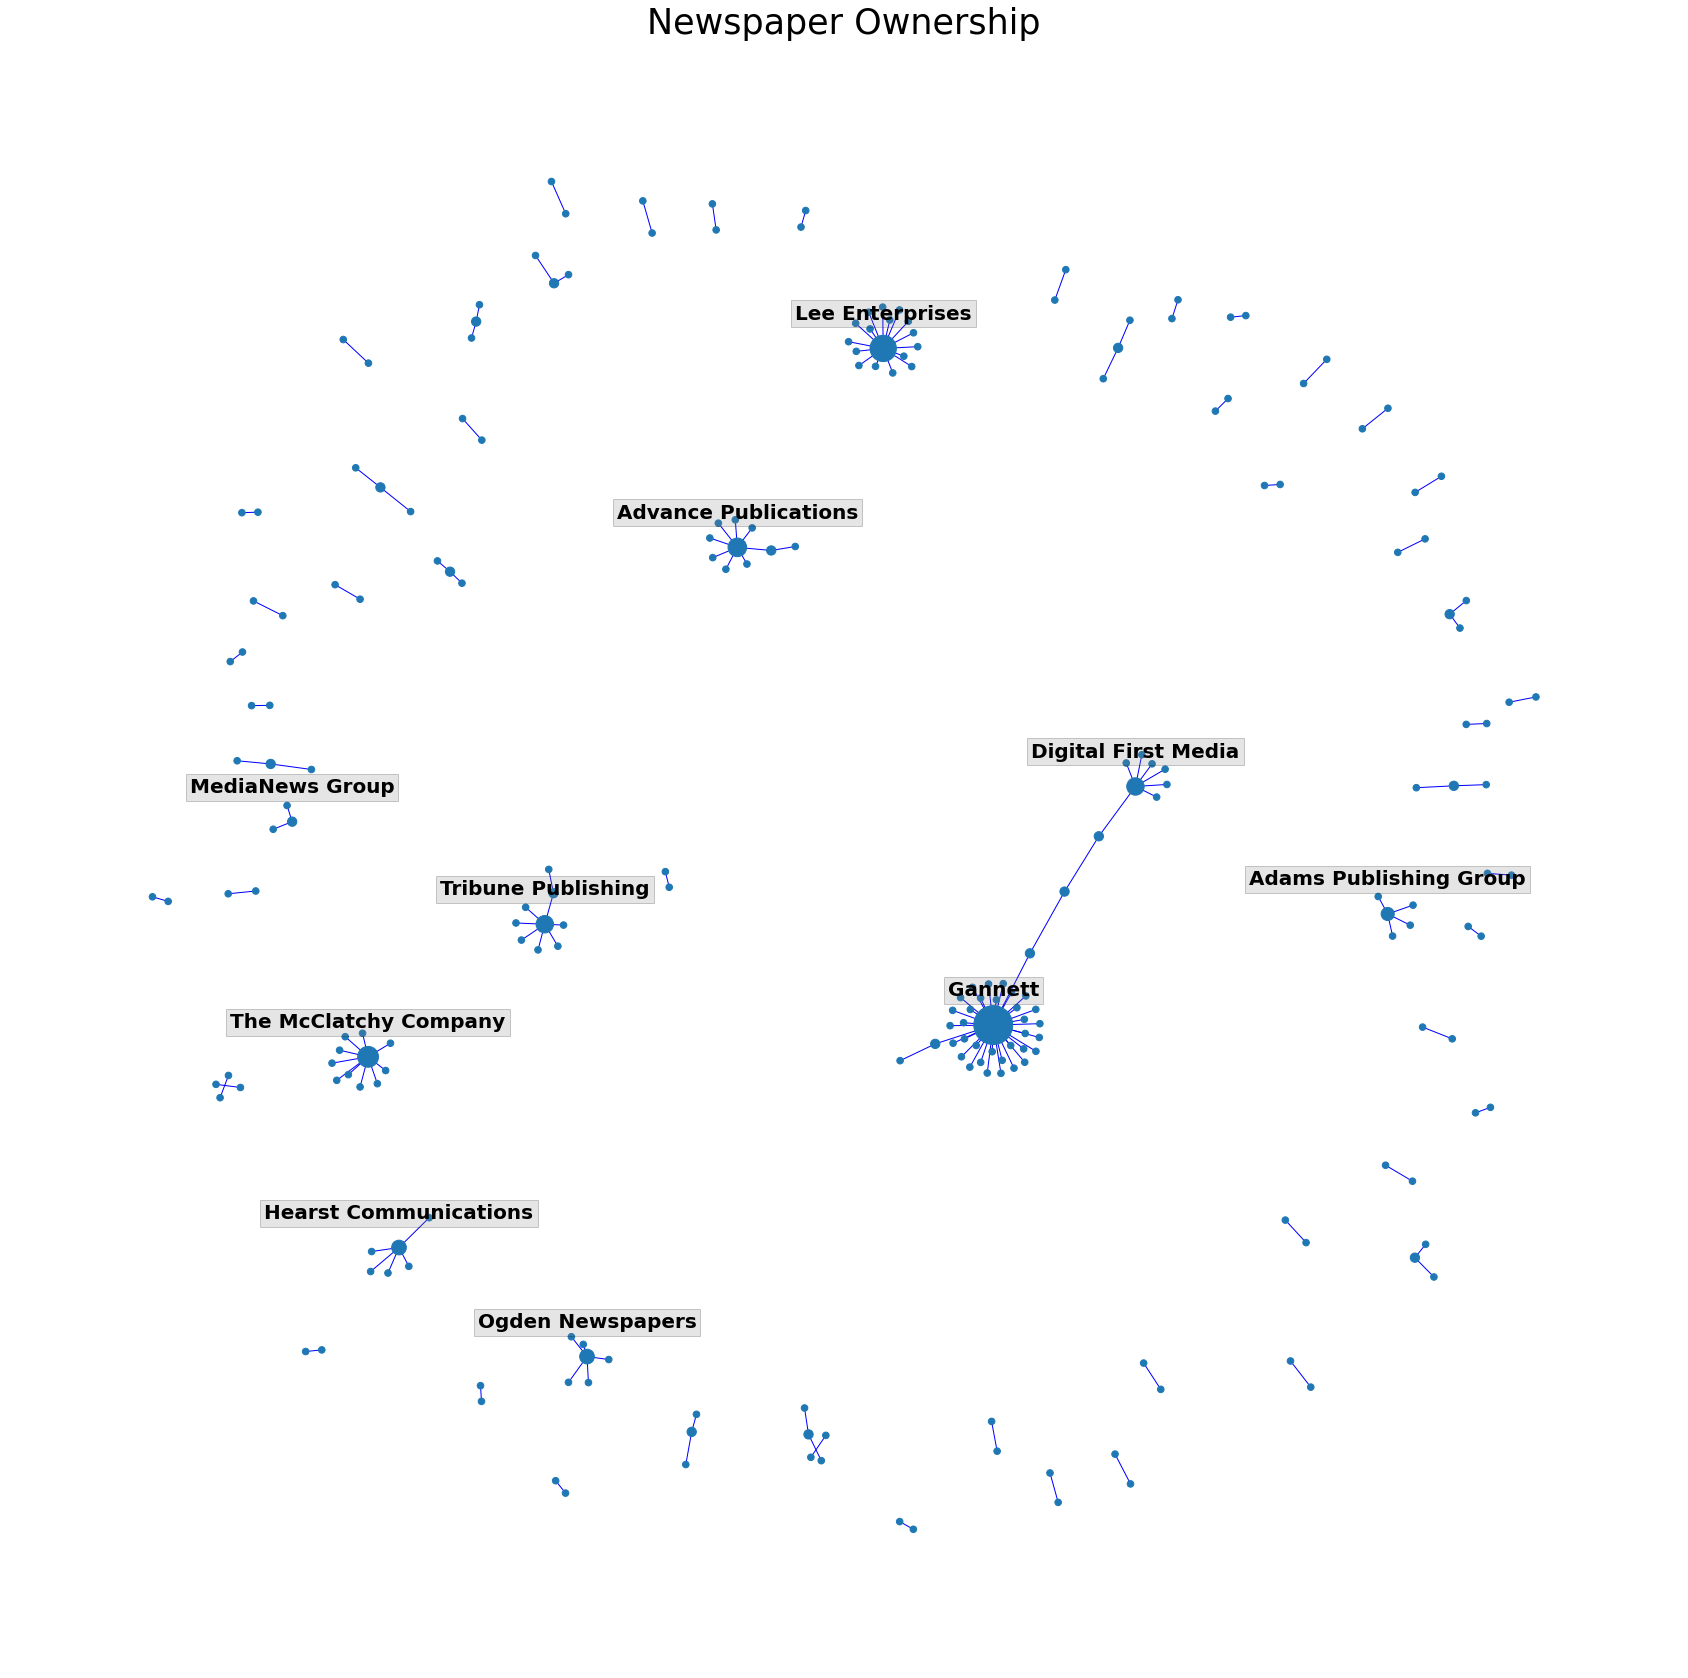

In [ ]:
print(nx.info(G))
pos = nx.spring_layout(G)
degCent = nx.degree_centrality(G)
size = nx.degree_centrality(G).values()
node_size =  [v*10000 for v in size]
plt.figure(figsize=(30,30))
plt.title('Newspaper Ownership',fontsize = 35)

labels = {}    
centrality_d = nx.degree_centrality(G).items()
top_10_cental = {k: v for k, v in sorted(centrality_d, key=lambda item: item[1], reverse=True)[:10]}
for node in G.nodes():
    if node in top_10_cental:
        #set the node name as the key and the label as its value 
        labels[node] = node
        
nx.draw_networkx(G, pos=pos, with_labels=False,arrows=False,
                 edge_color='blue', node_size=node_size,)

pos_higher = {}
y_off = 0.05  # offset on the y axis

for k, v in pos.items():
    pos_higher[k] = (v[0], v[1]+y_off)

nx.draw_networkx_labels(G,pos_higher,labels,font_size=20,font_color='black', font_weight='bold', bbox=dict(facecolor='grey', alpha=0.2))

plt.axis('off')
plt.savefig('network_newspaper_ownership.pdf')

In [ ]:
#nodes with highest degree centrality
sorted(degCent, key=degCent.get, reverse=True)[:5]

['Gannett',
 'Lee Enterprises',
 'The McClatchy Company',
 'Advance Publications',
 'Digital First Media']

In [ ]:
#adding the degree centrality to the dataframe
df['degree_centrality_o1'] = df['owner1'].map(degCent)
for i in range(len(df)):
    if df['owner2'][i] != 'None':
        df['degree_centrality_o2'][i] = degCent[df['owner2'][i]]
        df['degree_comp'] = df['degree_centrality_o1'] + df['degree_centrality_o2']
    else:
        df['degree_centrality_o2'][i] = float(0.0)
        df['degree_comp'] = df['degree_centrality_o1']
        
#df.to_csv('data/newspapers_cut.csv')


/var/folders/fc/vhrg50qd74x2j3j9gbnl92140000gn/T/ipykernel_17189/2558634043.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['degree_centrality_o2'][i] = float(0.0)
/var/folders/fc/vhrg50qd74x2j3j9gbnl92140000gn/T/ipykernel_17189/2558634043.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['degree_centrality_o2'][i] = degCent[df['owner2'][i]]


importing cdc dataset on health stats

In [ ]:
df = pd.read_csv('data/newspapers_cut.csv',index_col=0).reset_index(drop=True)
city_health = pd.read_csv('data/PLACES__Local_Data_for_Better_Health__Place_Data_2021_release.csv')
print(city_health.describe())
city_health.head()

               Year    Data_Value  Low_Confidence_Limit  \
count  1.685026e+06  1.653627e+06          1.653627e+06   
mean   2.018730e+03  3.169459e+01          2.986108e+01   
std    4.441368e-01  2.524776e+01          2.484915e+01   
min    2.018000e+03  3.000000e-01          3.000000e-01   
25%    2.018000e+03  1.160000e+01          1.010000e+01   
50%    2.019000e+03  2.400000e+01          2.170000e+01   
75%    2.019000e+03  4.100000e+01          3.900000e+01   
max    2.019000e+03  9.710000e+01          9.650000e+01   

       High_Confidence_Limit  TotalPopulation    LocationID  
count           1.653627e+06     1.685026e+06  1.685026e+06  
mean            3.356847e+01     8.037057e+03  2.989833e+06  
std             2.566080e+01     6.701168e+04  1.542454e+06  
min             4.000000e-01     5.000000e+01  1.001000e+05  
25%             1.300000e+01     3.630000e+02  1.772676e+06  
50%             2.640000e+01     1.120000e+03  2.960842e+06  
75%             4.400000e+01     4

Year StateAbbr StateDesc  LocationName DataSource         Category  \
0  2019        AL   Alabama       Carlton      BRFSS  Health Outcomes   
1  2019        AL   Alabama        Chatom      BRFSS  Health Outcomes   
2  2019        AL   Alabama  Collinsville      BRFSS  Health Outcomes   
3  2019        AL   Alabama        Colony      BRFSS  Health Outcomes   
4  2019        AL   Alabama       Coosada      BRFSS  Health Outcomes   

                                   Measure Data_Value_Unit  \
0      Stroke among adults aged >=18 years               %   
1     Obesity among adults aged >=18 years               %   
2      Stroke among adults aged >=18 years               %   
3  Depression among adults aged >=18 years               %   
4      Stroke among adults aged >=18 years               %   

           Data_Value_Type  Data_Value  ... Data_Value_Footnote  \
0  Age-adjusted prevalence         5.9  ...                 NaN   
1         Crude prevalence        40.8  ...                 NaN   
2         Crude prevalence         5.3  ...                 NaN   
3         Crude prevalence        19.4  ...                 NaN   
4         Crude prevalence         4.9  ...                 NaN   

  Low_Confidence_Limit  High_Confidence_Limit  TotalPopulation  \
0                  5.3                    6.6               65   
1                 39.5                   42.0             1288   
2                  4.7                    6.0             1983   
3                 18.2                   20.9              268   
4                  4.6                    5.3             1226   

                        Geolocation LocationID  CategoryID   MeasureId  \
0   POINT (-87.8385235 31.34655389)     112112     HLTHOUT      STROKE   
1  POINT (-88.24602114 31.46914557)     114008     HLTHOUT     OBESITY   
2    POINT (-85.865567 34.26230655)     116600     HLTHOUT      STROKE   
3    POINT (-86.8939975 33.9372899)     116684     HLTHOUT  DEPRESSION   
4   POINT (-86.3195555 32.49141923)     117176     HLTHOUT      STROKE   

  DataValueTypeID Short_Question_Text  
0       AgeAdjPrv              Stroke  
1          CrdPrv             Obesity  
2          CrdPrv              Stroke  
3          CrdPrv          Depression  
4          CrdPrv              Stroke  

[5 rows x 21 columns]

In [ ]:
city_health.columns

Index(['Year', 'StateAbbr', 'StateDesc', 'LocationName', 'DataSource',
       'Category', 'Measure', 'Data_Value_Unit', 'Data_Value_Type',
       'Data_Value', 'Data_Value_Footnote_Symbol', 'Data_Value_Footnote',
       'Low_Confidence_Limit', 'High_Confidence_Limit', 'TotalPopulation',
       'Geolocation', 'LocationID', 'CategoryID', 'MeasureId',
       'DataValueTypeID', 'Short_Question_Text'],
      dtype='object')

In [ ]:
#limiting the dataframe to only the cities that have health data
health_df = city_health[city_health['LocationName'].isin(df['City'])]
print(len(health_df))
print(len(set(health_df['LocationName'])))

46372
128


In [ ]:
health_df[health_df['Data_Value_Unit'] != '%'] #checking for any data that is not in percentage

Empty DataFrame
Columns: [Year, StateAbbr, StateDesc, LocationName, DataSource, Category, Measure, Data_Value_Unit, Data_Value_Type, Data_Value, Data_Value_Footnote_Symbol, Data_Value_Footnote, Low_Confidence_Limit, High_Confidence_Limit, TotalPopulation, Geolocation, LocationID, CategoryID, MeasureId, DataValueTypeID, Short_Question_Text]
Index: []

[0 rows x 21 columns]

In [ ]:
#grouping by city
city_health_grouped = health_df.groupby('LocationName')
city_health_grouped['LocationName'].count()
#reorganizing the dataframe so each measure is in a separate column
city_list = []
for citydf in list(city_health_grouped):
    measure = list(citydf[1]['Measure'])
    value = list(citydf[1]['Data_Value'])

    d = dict(zip(measure, value))
    city_df = pd.DataFrame(d, index=[citydf[0]])
    city_list.append(city_df)
        
city_df = pd.concat(city_list)    

#merging the city health data with the city data
city_df = df.merge(city_df, left_on='City', right_on=city_df.index)

In [ ]:
city_df.describe()

degree_centrality_o1  degree_centrality_o2  degree_comp  \
count            151.000000            151.000000   151.000000   
mean               0.051403              0.000545     0.051403   
std                0.057494              0.002797     0.057494   
min                0.004329              0.000000     0.004329   
25%                0.004329              0.000000     0.004329   
50%                0.030303              0.000000     0.030303   
75%                0.069264              0.000000     0.069264   
max                0.151515              0.030303     0.151515   

       Arthritis among adults aged >=18 years  \
count                              145.000000   
mean                                25.582069   
std                                  5.409016   
min                                 12.400000   
25%                                 22.600000   
50%                                 25.200000   
75%                                 27.800000   
max                                 42.700000   

       High blood pressure among adults aged >=18 years  \
count                                        150.000000   
mean                                          32.308667   
std                                            5.683757   
min                                           16.400000   
25%                                           28.525000   
50%                                           32.050000   
75%                                           36.250000   
max                                           50.000000   

       Mammography use among women aged 50-74 years  \
count                                    146.000000   
mean                                      73.795890   
std                                        4.478683   
min                                       58.500000   
25%                                       71.650000   
50%                                       74.450000   
75%                                       77.200000   
max                                       84.500000   

       Fecal occult blood test, sigmoidoscopy, or colonoscopy among adults aged 50-75 years  \
count                                         150.000000                                      
mean                                           63.296000                                      
std                                             6.289694                                      
min                                            42.700000                                      
25%                                            59.725000                                      
50%                                            63.700000                                      
75%                                            67.400000                                      
max                                            74.200000                                      

       Fair or poor self-rated health status among adults aged >=18 years  \
count                                         148.000000                    
mean                                           19.875000                    
std                                             5.732363                    
min                                             8.900000                    
25%                                            15.575000                    
50%                                            19.400000                    
75%                                            22.700000                    
max                                            41.500000                    

       All teeth lost among adults aged >=65 years  \
count                                   146.000000   
mean                                     15.518493   
std                                       4.733490   
min                                       7.300000   
25%                                      12.350000   
50%                                      15.300000   
75%           

In [ ]:
city_df.columns

Index(['State', 'City', 'Title', 'url', 'owner1', 'owner2',
       'degree_centrality_o1', 'degree_centrality_o2', 'degree_comp',
       'Arthritis among adults aged >=18 years',
       'High blood pressure among adults aged >=18 years',
       'Mammography use among women aged 50-74 years',
       'Fecal occult blood test, sigmoidoscopy, or colonoscopy among adults aged 50-75 years',
       'Fair or poor self-rated health status among adults aged >=18 years',
       'All teeth lost among adults aged >=65 years',
       'Visits to doctor for routine checkup within the past year among adults aged >=18 years',
       'Depression among adults aged >=18 years',
       'Sleeping less than 7 hours among adults aged >=18 years',
       'Cervical cancer screening among adult women aged 21-65 years',
       'Current smoking among adults aged >=18 years',
       'Obesity among adults aged >=18 years',
       'Cancer (excluding skin cancer) among adults aged >=18 years',
       'Older adult men a

In [ ]:
city_df.to_csv('data/city_health_data.csv')
#renaming columns[,State,City,Title,url,owner1,owner2,degree_centrality_o1,degree_centrality_o2,degree_comp,arthritis,high_blood_pressure,mammography,colonoscopy_test,poor_health_status,all_teeth_lost,routine_checkup,depression,sleep_<7hours,cervical_cancer_screening,smoking,obesity,cancer,older_men_preventive_services,kidney_disease,diabetes,medicine_high_blood_pressure,asthma,high_cholesterol,binge_drinking,no_physical_activity,no_health_insurance,dentist,stroke,bad_mental_health,pulmonary_disease,older_women_preventive_services,bad_physical_health,heart_disease,cholesterol_screening

Descriptive Statistics on Health Data by City

In [ ]:
city_df = pd.read_csv('data/city_health_data.csv',index_col= 0)
city_df.head()

State        City                       Title                 url  \
0  Alabama  Birmingham             Birmingham News   al.com/birmingham   
1   Alaska   Anchorage        Alaska dispatch news  http://www.adn.com   
2   Alaska   Fairbanks  Fairbanks Daily News-Miner       Newsminer.com   
3  Arizona   Flagstaff           Arizona Daily Sun      azdailysun.com   
4  Arizona      Tucson          Arizona Daily Star          tucson.com   

                        owner1 owner2  degree_centrality_o1  \
0         Advance Publications   None              0.034632   
1                  Binkley Co.   None              0.004329   
2  Helen E. Snedden Foundation   None              0.004329   
3              Lee Enterprises   None              0.069264   
4              Lee Enterprises   None              0.069264   

   degree_centrality_o2  degree_comp  arthritis  ...  no_physical_activity  \
0                   0.0     0.034632       25.2  ...                  23.7   
1                   0.0     0.004329       31.4  ...                  22.8   
2                   0.0     0.004329       20.2  ...                  24.6   
3                   0.0     0.069264       20.8  ...                  18.0   
4                   0.0     0.069264       21.0  ...                  25.6   

   no_health_insurance  dentist  stroke  bad_mental_health  pulmonary_disease  \
0                 10.6     70.4     2.6               13.4                5.9   
1                  6.0     73.1     2.9               12.6                7.0   
2                 13.5     63.9     2.5               15.7                5.2   
3                 14.7     63.8     1.9               17.7                4.6   
4                 21.0     57.3     3.2               16.7                6.8   

   older_women_preventive_services  bad_physical_health  heart_disease  \
0                             34.2                 12.4            5.7   
1                             45.8                  9.6            5.1   
2                             23.0                 10.7            4.1   
3                             22.6                 10.4            3.3   
4                             25.0                 14.4            5.8   

   cholesterol_screening  
0                   87.6  
1                   91.4  
2                   75.8  
3                   77.2  
4                   82.1  

[5 rows x 39 columns]

In [ ]:
healthcols = city_df.iloc[:,9:]
print(city_df.info())
missing = city_df[healthcols.isna().any(axis=1)] #checking which cities have missing health data
print(missing)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151 entries, 0 to 150
Data columns (total 39 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   State                            151 non-null    object 
 1   City                             151 non-null    object 
 2   Title                            151 non-null    object 
 3   url                              151 non-null    object 
 4   owner1                           151 non-null    object 
 5   owner2                           150 non-null    object 
 6   degree_centrality_o1             151 non-null    float64
 7   degree_centrality_o2             151 non-null    float64
 8   degree_comp                      151 non-null    float64
 9   arthritis                        145 non-null    float64
 10  high_blood_pressure              150 non-null    float64
 11  mammography                      146 non-null    float64
 12  colonoscopy_test      

In [ ]:
#removing duplate health stats where there are multiple newspapers in the same city
healthstats = city_df.drop_duplicates('City')
healthstats.head()

State        City                       Title                 url  \
0  Alabama  Birmingham             Birmingham News   al.com/birmingham   
1   Alaska   Anchorage        Alaska dispatch news  http://www.adn.com   
2   Alaska   Fairbanks  Fairbanks Daily News-Miner       Newsminer.com   
3  Arizona   Flagstaff           Arizona Daily Sun      azdailysun.com   
4  Arizona      Tucson          Arizona Daily Star          tucson.com   

                        owner1 owner2  degree_centrality_o1  \
0         Advance Publications   None              0.034632   
1                  Binkley Co.   None              0.004329   
2  Helen E. Snedden Foundation   None              0.004329   
3              Lee Enterprises   None              0.069264   
4              Lee Enterprises   None              0.069264   

   degree_centrality_o2  degree_comp  arthritis  ...  no_physical_activity  \
0                   0.0     0.034632       25.2  ...                  23.7   
1                   0.0     0.004329       31.4  ...                  22.8   
2                   0.0     0.004329       20.2  ...                  24.6   
3                   0.0     0.069264       20.8  ...                  18.0   
4                   0.0     0.069264       21.0  ...                  25.6   

   no_health_insurance  dentist  stroke  bad_mental_health  pulmonary_disease  \
0                 10.6     70.4     2.6               13.4                5.9   
1                  6.0     73.1     2.9               12.6                7.0   
2                 13.5     63.9     2.5               15.7                5.2   
3                 14.7     63.8     1.9               17.7                4.6   
4                 21.0     57.3     3.2               16.7                6.8   

   older_women_preventive_services  bad_physical_health  heart_disease  \
0                             34.2                 12.4            5.7   
1                             45.8                  9.6            5.1   
2                             23.0                 10.7            4.1   
3                             22.6                 10.4            3.3   
4                             25.0                 14.4            5.8   

   cholesterol_screening  
0                   87.6  
1                   91.4  
2                   75.8  
3                   77.2  
4                   82.1  

[5 rows x 39 columns]

In [ ]:
#getting range of values for each measure
mins = healthstats.iloc[:,2:].min(axis=1)
maxs = healthstats.iloc[:,2:].max(axis=1)
measure = healthstats.iloc[:,2:]
d = dict(zip(measure.columns, list(zip(mins,maxs))))
print(d)

{'Title': (0.0, 87.6), 'url': (0.0, 91.4), 'owner1': (0.0, 81.0), 'owner2': (0.0, 83.7), 'degree_centrality_o1': (0.0, 82.1), 'degree_centrality_o2': (0.0, 82.3), 'degree_comp': (0.0, 79.0), 'arthritis': (0.0, 78.0), 'high_blood_pressure': (0.0, 83.0), 'mammography': (0.0, 70.7), 'colonoscopy_test': (0.0, 88.5), 'poor_health_status': (0.0, 74.3), 'all_teeth_lost': (0.0, 83.4), 'routine_checkup': (0.0, 84.5), 'depression': (0.0, 88.3), 'sleep_<7hours': (0.0, 83.4), 'cervical_cancer_screening': (0.0, 86.4), 'smoking': (0.0, 88.0), 'obesity': (0.0, 85.2), 'cancer': (0.0, 83.8), 'older_men_preventive_services': (0.0, 89.9), 'kidney_disease': (0.0, 85.3), 'diabetes': (0.0, 83.1), 'medicine_high_blood_pressure': (0.0, 82.3), 'asthma': (0.0, 86.0), 'high_cholesterol': (0.0, 83.9), 'binge_drinking': (0.0, 82.3), 'no_physical_activity': (0.0, 86.2), 'no_health_insurance': (0.0, 82.9), 'dentist': (0.0, 81.9), 'stroke': (0.0043290043290043, 85.5), 'bad_mental_health': (0.0, 83.7), 'pulmonary_dise

/var/folders/fc/vhrg50qd74x2j3j9gbnl92140000gn/T/ipykernel_20211/269976204.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mins = healthstats.iloc[:,2:].min(axis=1)
/var/folders/fc/vhrg50qd74x2j3j9gbnl92140000gn/T/ipykernel_20211/269976204.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  maxs = healthstats.iloc[:,2:].max(axis=1)


<AxesSubplot:>

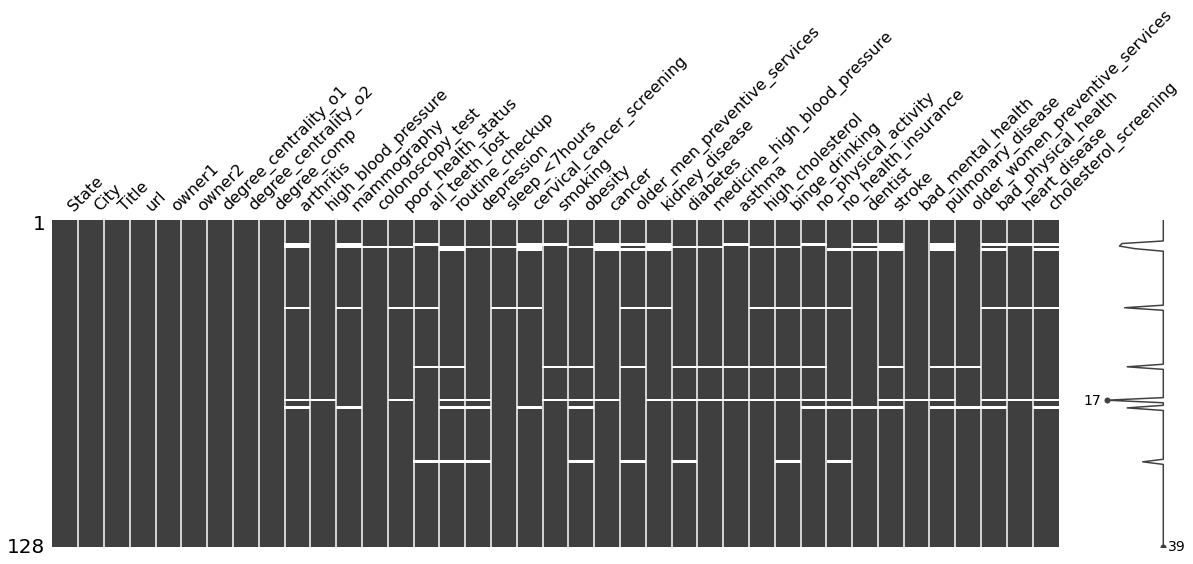

In [ ]:
import missingno as mno
mno.matrix(healthstats, figsize = (20, 6))

In [ ]:
#filling in missing values with regression model

lr = LinearRegression()

def random_imputation(df, feature):
    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)
    
    return df


In [ ]:
health_features = healthstats.iloc[:,9:]
imp_data = health_features.copy()
for feature in imp_data.columns:
    imp_data[feature + '_imp'] = imp_data[feature]
    imp_data = random_imputation(imp_data, feature)

deter_data = pd.DataFrame(columns = ["det_" + name for name in health_features.columns])

for feature in health_features.columns:
        
    deter_data["det_" + feature] = imp_data[feature + "_imp"]
    parameters = list(set(imp_data.columns) - set(health_features.columns) - {feature + '_imp'})
    
    #fit Linear Regression model on randomly imputed data
    lr.fit(X = imp_data[parameters], y = imp_data[feature + '_imp'])
    
    #preserve the index of the missing data from the original dataframe
    deter_data.loc[imp_data[feature].isnull(), "det_" + feature] = lr.predict(imp_data[parameters])[imp_data[feature].isnull()]




In [ ]:
#merging the imputed data with the original dataframe
healthstats_imp = healthstats.merge(deter_data, left_index=True, right_index=True)
#saving the imputed data
healthstats_imp.to_parquet('data/city_health_data_imp.parquet')

State        City                       Title                 url  \
0  Alabama  Birmingham             Birmingham News   al.com/birmingham   
1   Alaska   Anchorage        Alaska dispatch news  http://www.adn.com   
2   Alaska   Fairbanks  Fairbanks Daily News-Miner       Newsminer.com   
3  Arizona   Flagstaff           Arizona Daily Sun      azdailysun.com   
4  Arizona      Tucson          Arizona Daily Star          tucson.com   

                        owner1 owner2  degree_centrality_o1  \
0         Advance Publications   None              0.034632   
1                  Binkley Co.   None              0.004329   
2  Helen E. Snedden Foundation   None              0.004329   
3              Lee Enterprises   None              0.069264   
4              Lee Enterprises   None              0.069264   

   degree_centrality_o2  degree_comp  arthritis  ...  \
0                   0.0     0.034632       25.2  ...   
1                   0.0     0.004329       31.4  ...   
2                   0.0     0.004329       20.2  ...   
3                   0.0     0.069264       20.8  ...   
4                   0.0     0.069264       21.0  ...   

   det_no_physical_activity  det_no_health_insurance  det_dentist  det_stroke  \
0                      23.7                     10.6         70.4         2.6   
1                      22.8                      6.0         73.1         2.9   
2                      24.6                     13.5         63.9         2.5   
3                      18.0                     14.7         63.8         1.9   
4                      25.6                     21.0         57.3         3.2   

   det_bad_mental_health  det_pulmonary_disease  \
0                   13.4                    5.9   
1                   12.6                    7.0   
2                   15.7                    5.2   
3                   17.7                    4.6   
4                   16.7                    6.8   

   det_older_women_preventive_services  det_bad_physical_health  \
0                                 34.2                     12.4   
1                                 45.8                      9.6   
2                                 23.0                     10.7   
3                                 22.6                     10.4   
4                                 25.0                     14.4   

   det_heart_disease  det_cholesterol_screening  
0                5.7                       87.6  
1                5.1                       91.4  
2                4.1                       75.8  
3                3.3                       77.2  
4                5.8                       82.1  

[5 rows x 69 columns]

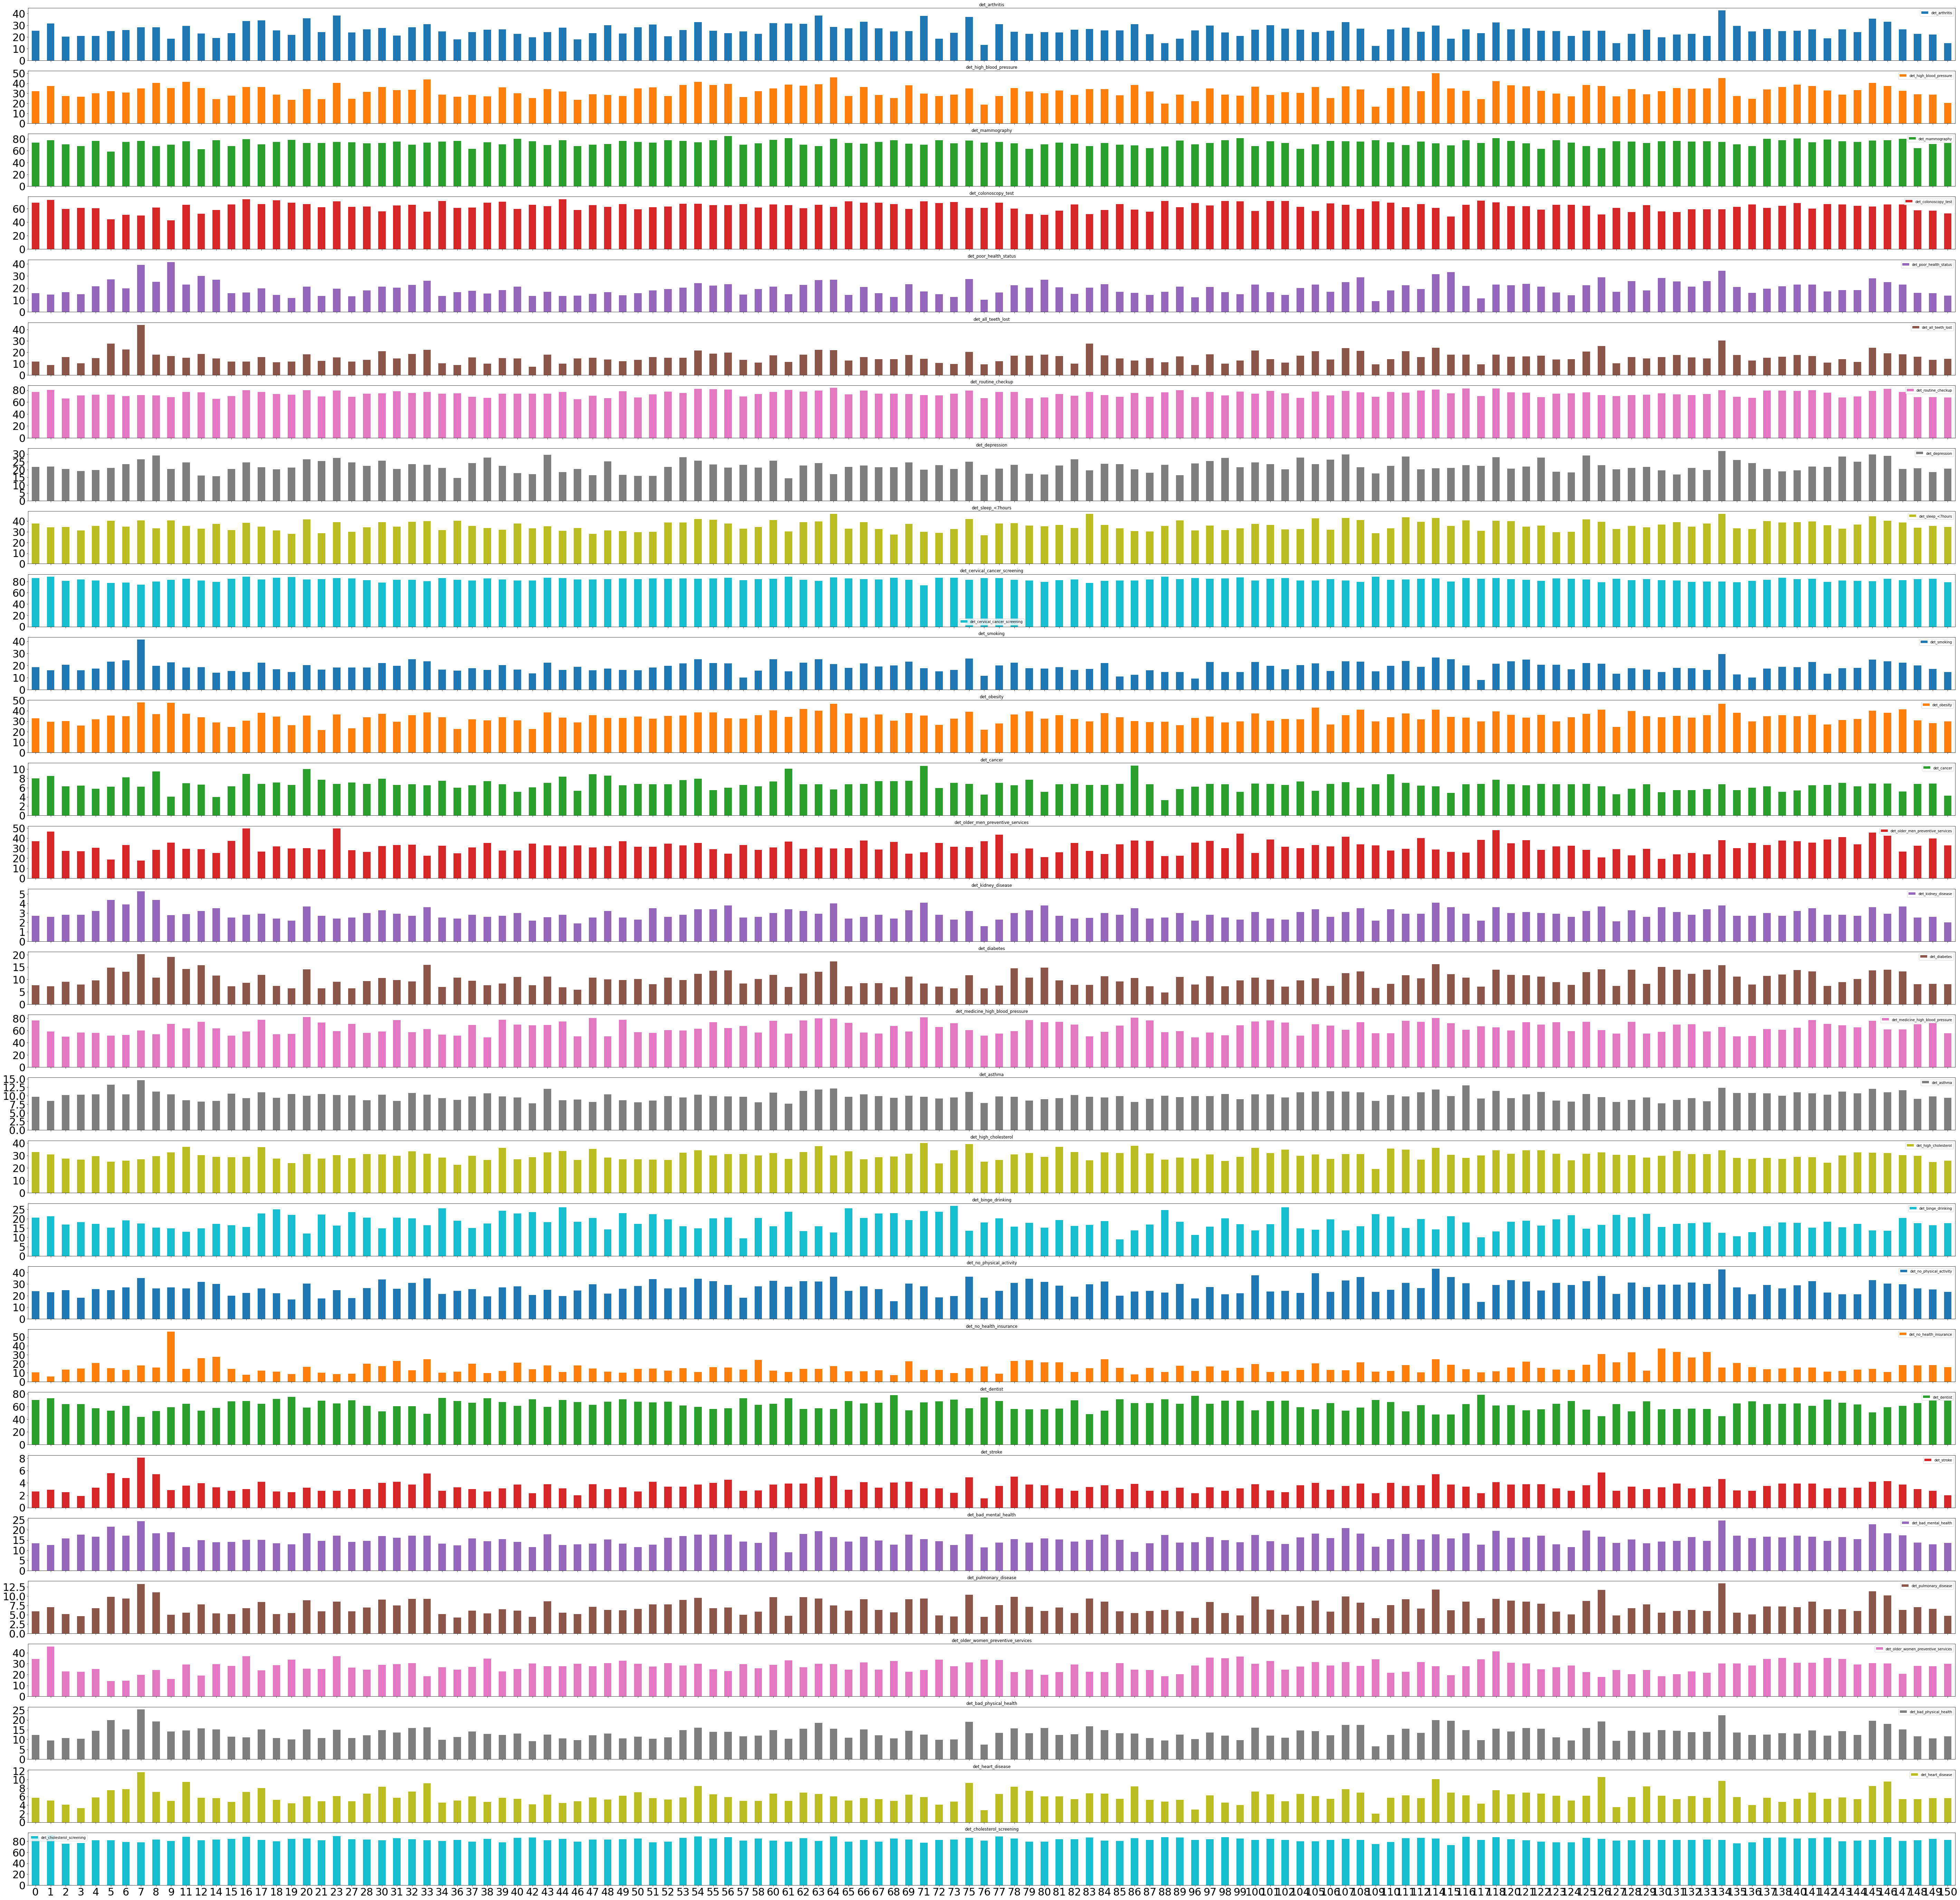

In [ ]:
axes = deter_data.plot.bar(rot=0, subplots=True, figsize=(100,100),fontsize=30)
axes[1]
plt.savefig('health_bars.pdf')

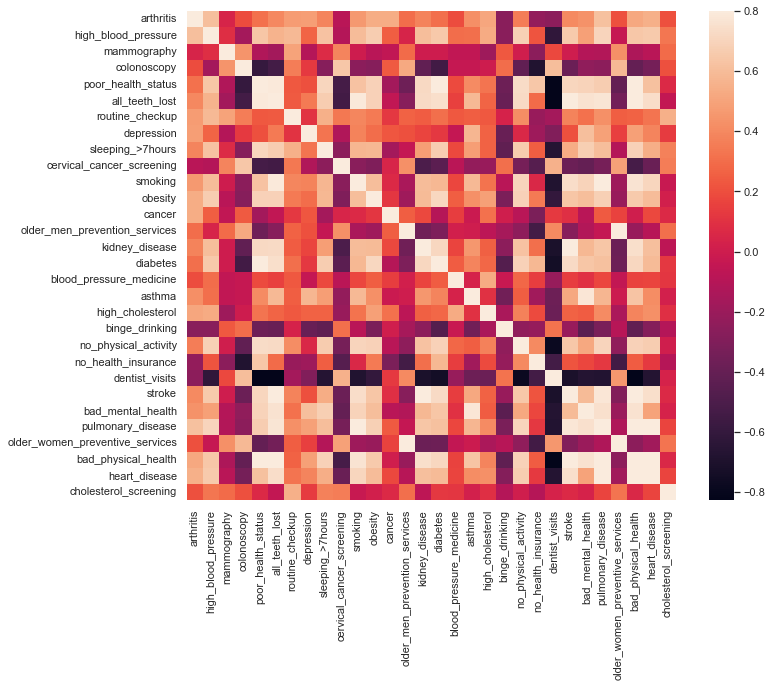

In [ ]:
#correlation matrix
corrmat = deter_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.savefig('corr_matrix.pdf')

/Users/cgottorff/Documents/ddgmtn/.env/lib/python3.9/site-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


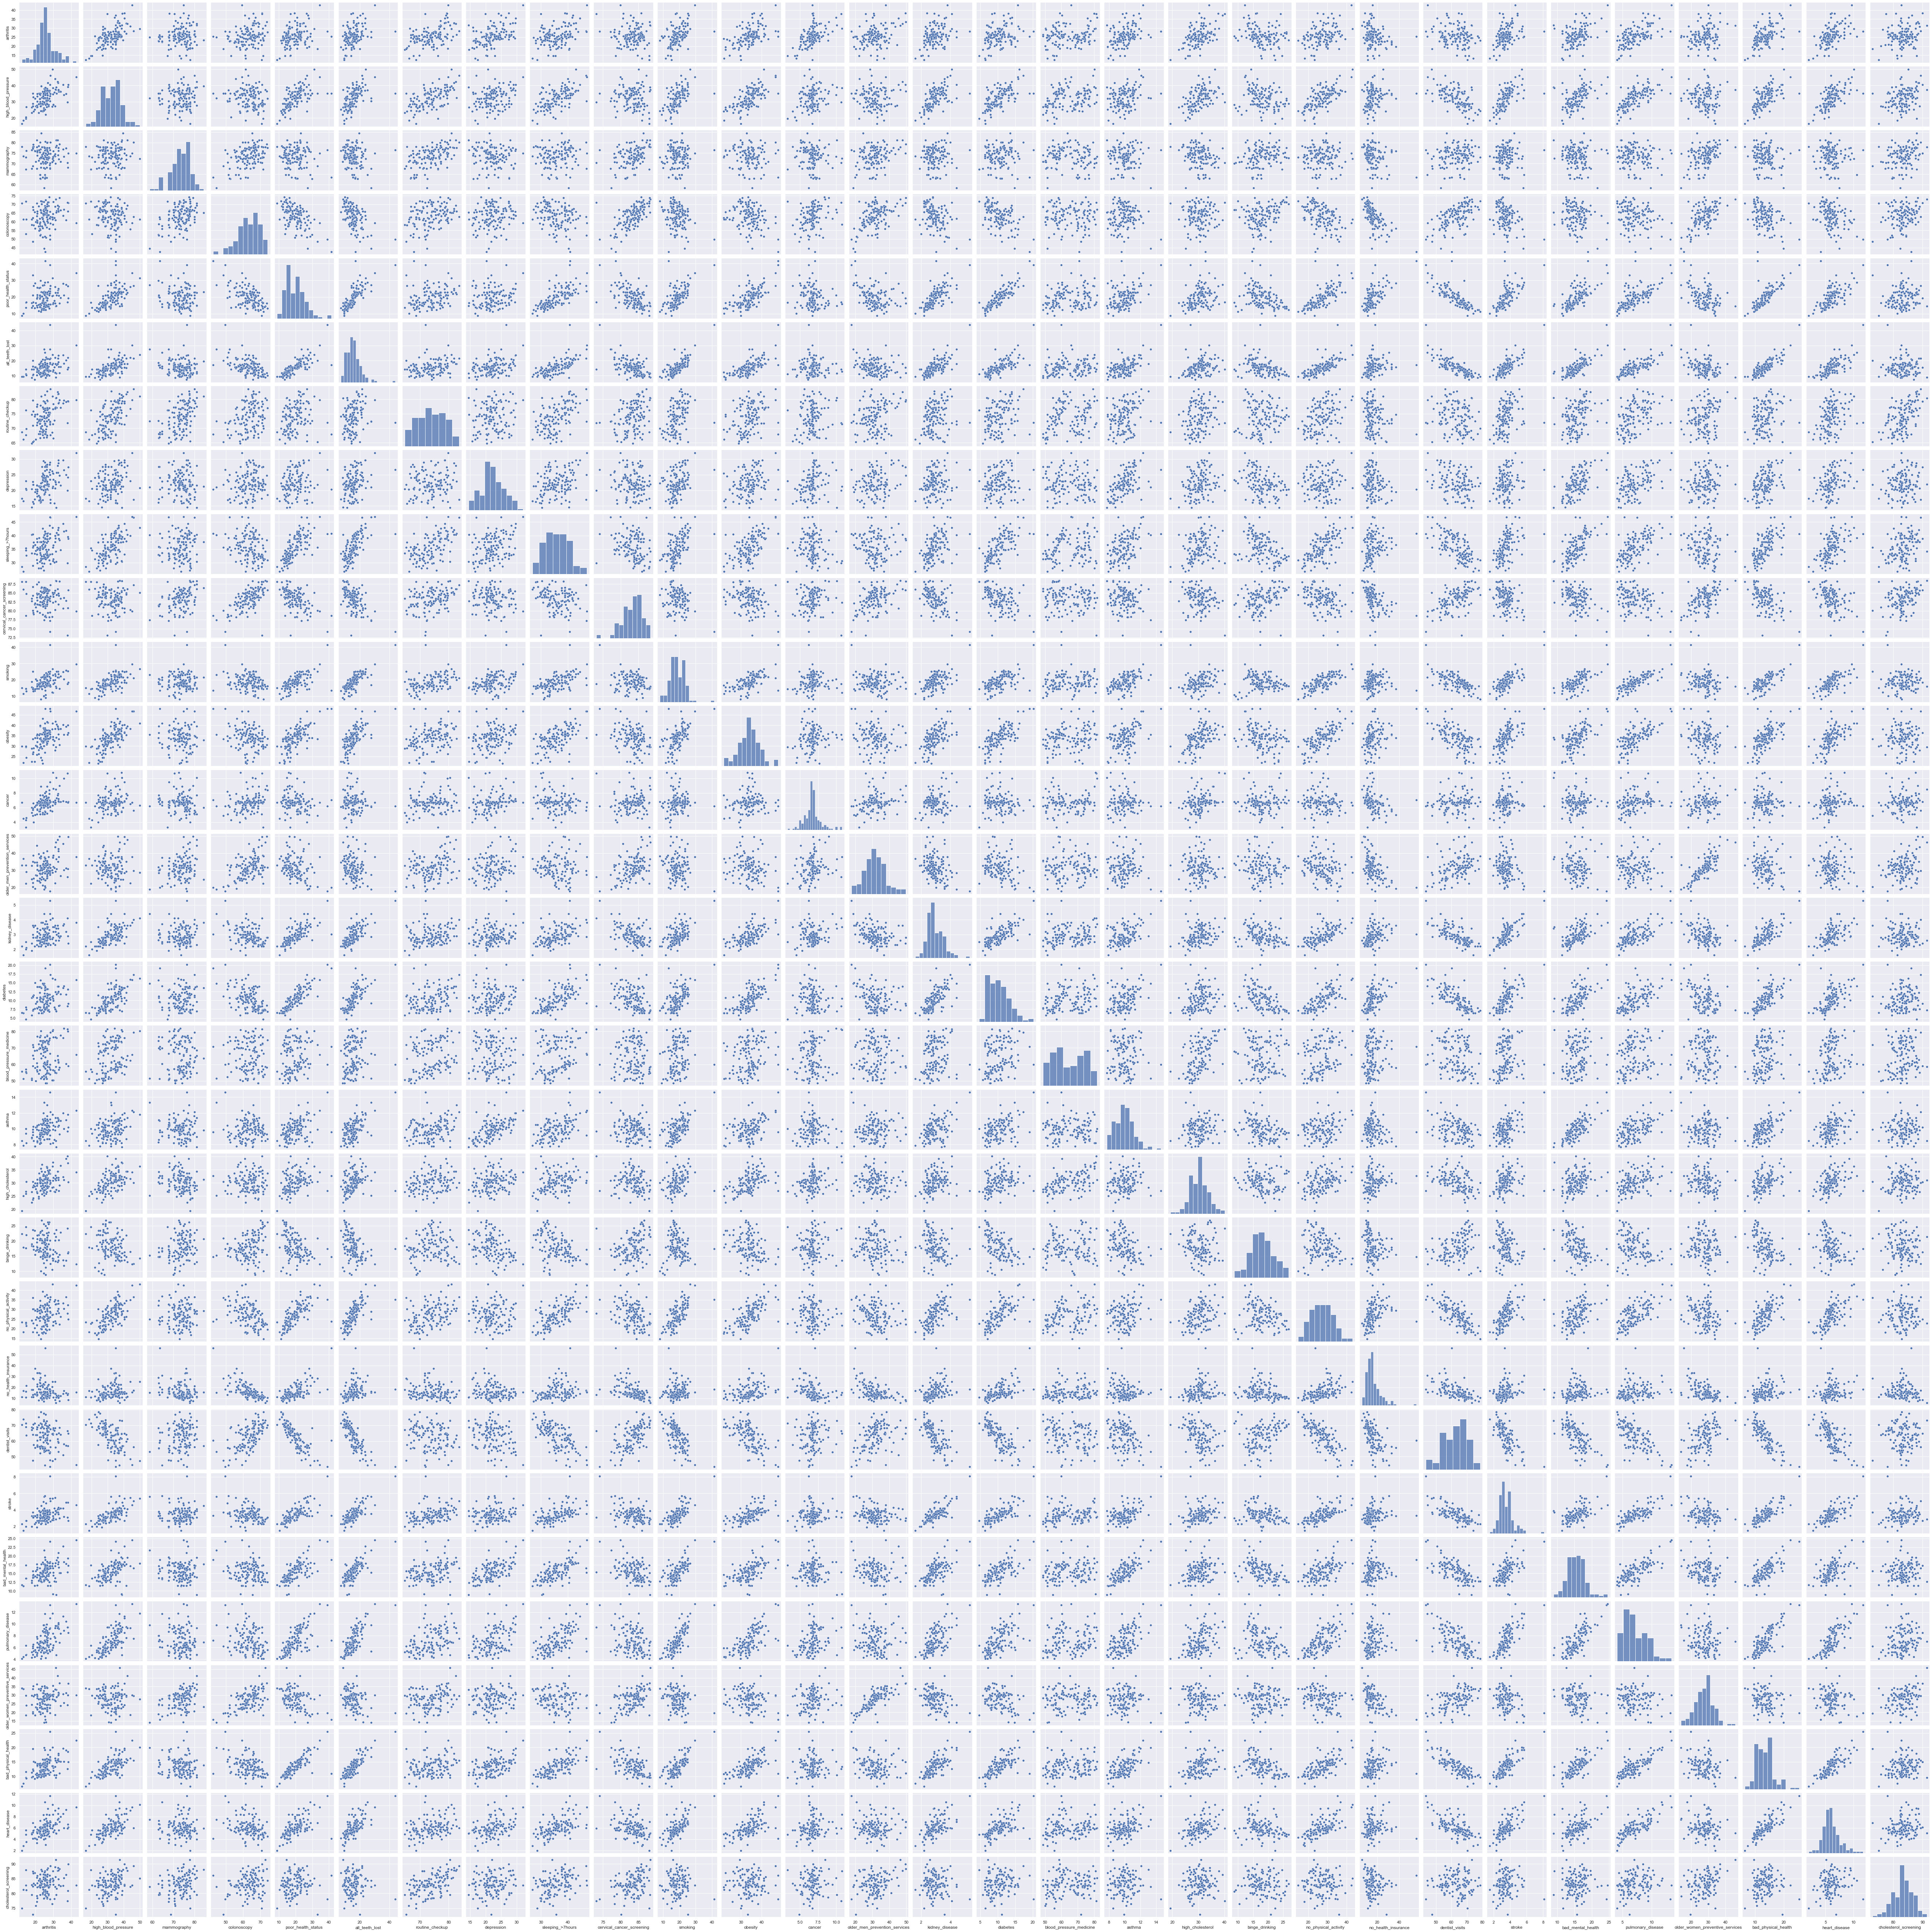

In [ ]:
sns.set()
sns.pairplot(deter_data, size = 2.5)
plt.savefig('health_scatter.pdf')


In [ ]:
deter_data.columns

Index(['arthritis', 'high_blood_pressure', 'mammography', 'colonoscopy',
       'poor_health_status', 'all_teeth_lost', 'routine_checkup', 'depression',
       'sleeping_>7hours', 'cervical_cancer_screening', 'smoking', 'obesity',
       'cancer', 'older_men_prevention_services', 'kidney_disease', 'diabetes',
       'blood_pressure_medicine', 'asthma', 'high_cholesterol',
       'binge_drinking', 'no_physical_activity', 'no_health_insurance',
       'dentist_visits', 'stroke', 'bad_mental_health', 'pulmonary_disease',
       'older_women_preventive_services', 'bad_physical_health',
       'heart_disease', 'cholesterol_screening'],
      dtype='object')

In [ ]:
#checking collinearity using variance Inflation factor

from statsmodels.stats.outliers_influence import variance_inflation_factor    

def get_vif(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]
        print(vif)

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

get_vif(deter_data)

[122.88521556843217, 192.85882232606366, 734.2561728736026, 691.1766157113921, 208.16018343333994, 106.14032879617018, 1786.968139520411, 212.59154967311687, 416.48613951467684, 2390.1937370390788, 171.4783913902068, 210.2867309869601, 120.19035484583505, 114.54481879785257, 182.71879841066885, 168.91019420950562, 95.31048017011976, 370.9854592754254, 248.53197624748643, 106.90954399199875, 219.22608511547196, 47.969436007298434, 597.8464021407805, 137.1946693395722, 559.6461921768965, 203.72639055782432, 141.5679551147628, 291.88273237693954, 125.60471549132755, 2190.1118284221993]
dropping 'cervical_cancer_screening' at index: 9
[119.40704411303975, 189.01901500875883, 733.6363253687866, 667.213982871964, 204.65125666704597, 106.13694398667073, 1752.9847854920763, 205.7781682589341, 398.5867246674944, 153.65848841776665, 207.73406437110788, 119.8965955582585, 111.81123505843792, 182.59110618873888, 167.2549424929699, 94.72180135162932, 366.38095921259827, 247.13089785066916, 106.8939

binge_drinking  no_health_insurance
0              20.6                 10.6
1              21.3                  6.0
2              16.8                 13.5
3              18.1                 14.7
4              17.1                 21.0
..              ...                  ...
146            13.5                 10.7
147            20.3                 18.5
148            17.6                 18.2
149            16.4                 18.6
150            17.6                 16.2

[128 rows x 2 columns]

GeoSpatial

In [ ]:
#getting long lat for city where newspapers in the article dataset are located
news_local = pd.read_csv('data/local_news.csv', index_col=0).reset_index(drop=True)
city_health = pd.read_parquet('data/city_health_data_imp.parquet')

#mering city health data with local news data to get newspapers left(1 in each city)
city_health_news = city_health.merge(news_local, left_on='url', right_on='domain')
domains = city_health_news['domain'].unique()

geo_health = pd.read_csv('data/PLACES__Local_Data_for_Better_Health__Place_Data_2021_release.csv')

newspapers_loc = []
for domain in domains:
    newspapers_loc.append(city_health[["State", "City", "owner1", "owner2"]][city_health["url"] == domain].values)
    
newspapers_loc = pd.DataFrame(np.concatenate(newspapers_loc))
newspapers_loc.columns = ["State", "City", "owner1", "owner2"]
newspapers_loc['url'] = domains
#chaning district Of columbia to district of columbia city to match geo_health
newspapers_loc.loc[newspapers_loc['State'] == 'District Of Columbia', 'State'] = 'District of Columbia'

newspapers_loc

#merge newspapers_loc with geo_health on State and City
geo_health = pd.merge(geo_health, newspapers_loc, left_on=['StateDesc', 'LocationName'], right_on=['State', 'City'])
geo_health = geo_health.drop_duplicates(subset=['StateDesc', 'LocationName'])

#turning geo point into lat long
'''input_token = "("
geo_health['Geolocation'] = geo_health['Geolocation'].str.replace('POINT','')
geo_health['Geolocation'] = geo_health['Geolocation'].str.replace(re.escape(input_token),'')
geo_health['Geolocation'] = geo_health['Geolocation'].str.replace(')','')'''
#turning string into tuple
'''lat = [float(i.strip().split()[0]) for i in geo_health['Geolocation']]
long = [float(i.strip().split()[1]) for i in geo_health['Geolocation']]'''

#aggregating data by city and adding urls
aggregation_functions = {'State':'first', 'City':'first', 'owner1':'first', 'owner2':'first', 'url':'sum'}
newspapers_loc = newspapers_loc.groupby(newspapers_loc['City']).aggregate(aggregation_functions)
newspapers_loc['url'] = newspapers_loc['url'].apply(lambda x: x.split('.com'))
newspapers_loc['url'] = newspapers_loc['url'].apply(lambda x: [i for i in x if i])

newspapers_loc['geometry'] = geo_health['Geolocation'].values

/var/folders/fc/vhrg50qd74x2j3j9gbnl92140000gn/T/ipykernel_20211/3756194858.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  news_local = pd.read_csv('data/local_news.csv', index_col=0).reset_index(drop=True)


In [ ]:
#one hot encoding owners
owners = list(set(newspapers_loc['owner1']))
y = pd.get_dummies(newspapers_loc.owner1)
newspapers_loc = pd.concat([newspapers_loc, y], axis=1)

<AxesSubplot:>

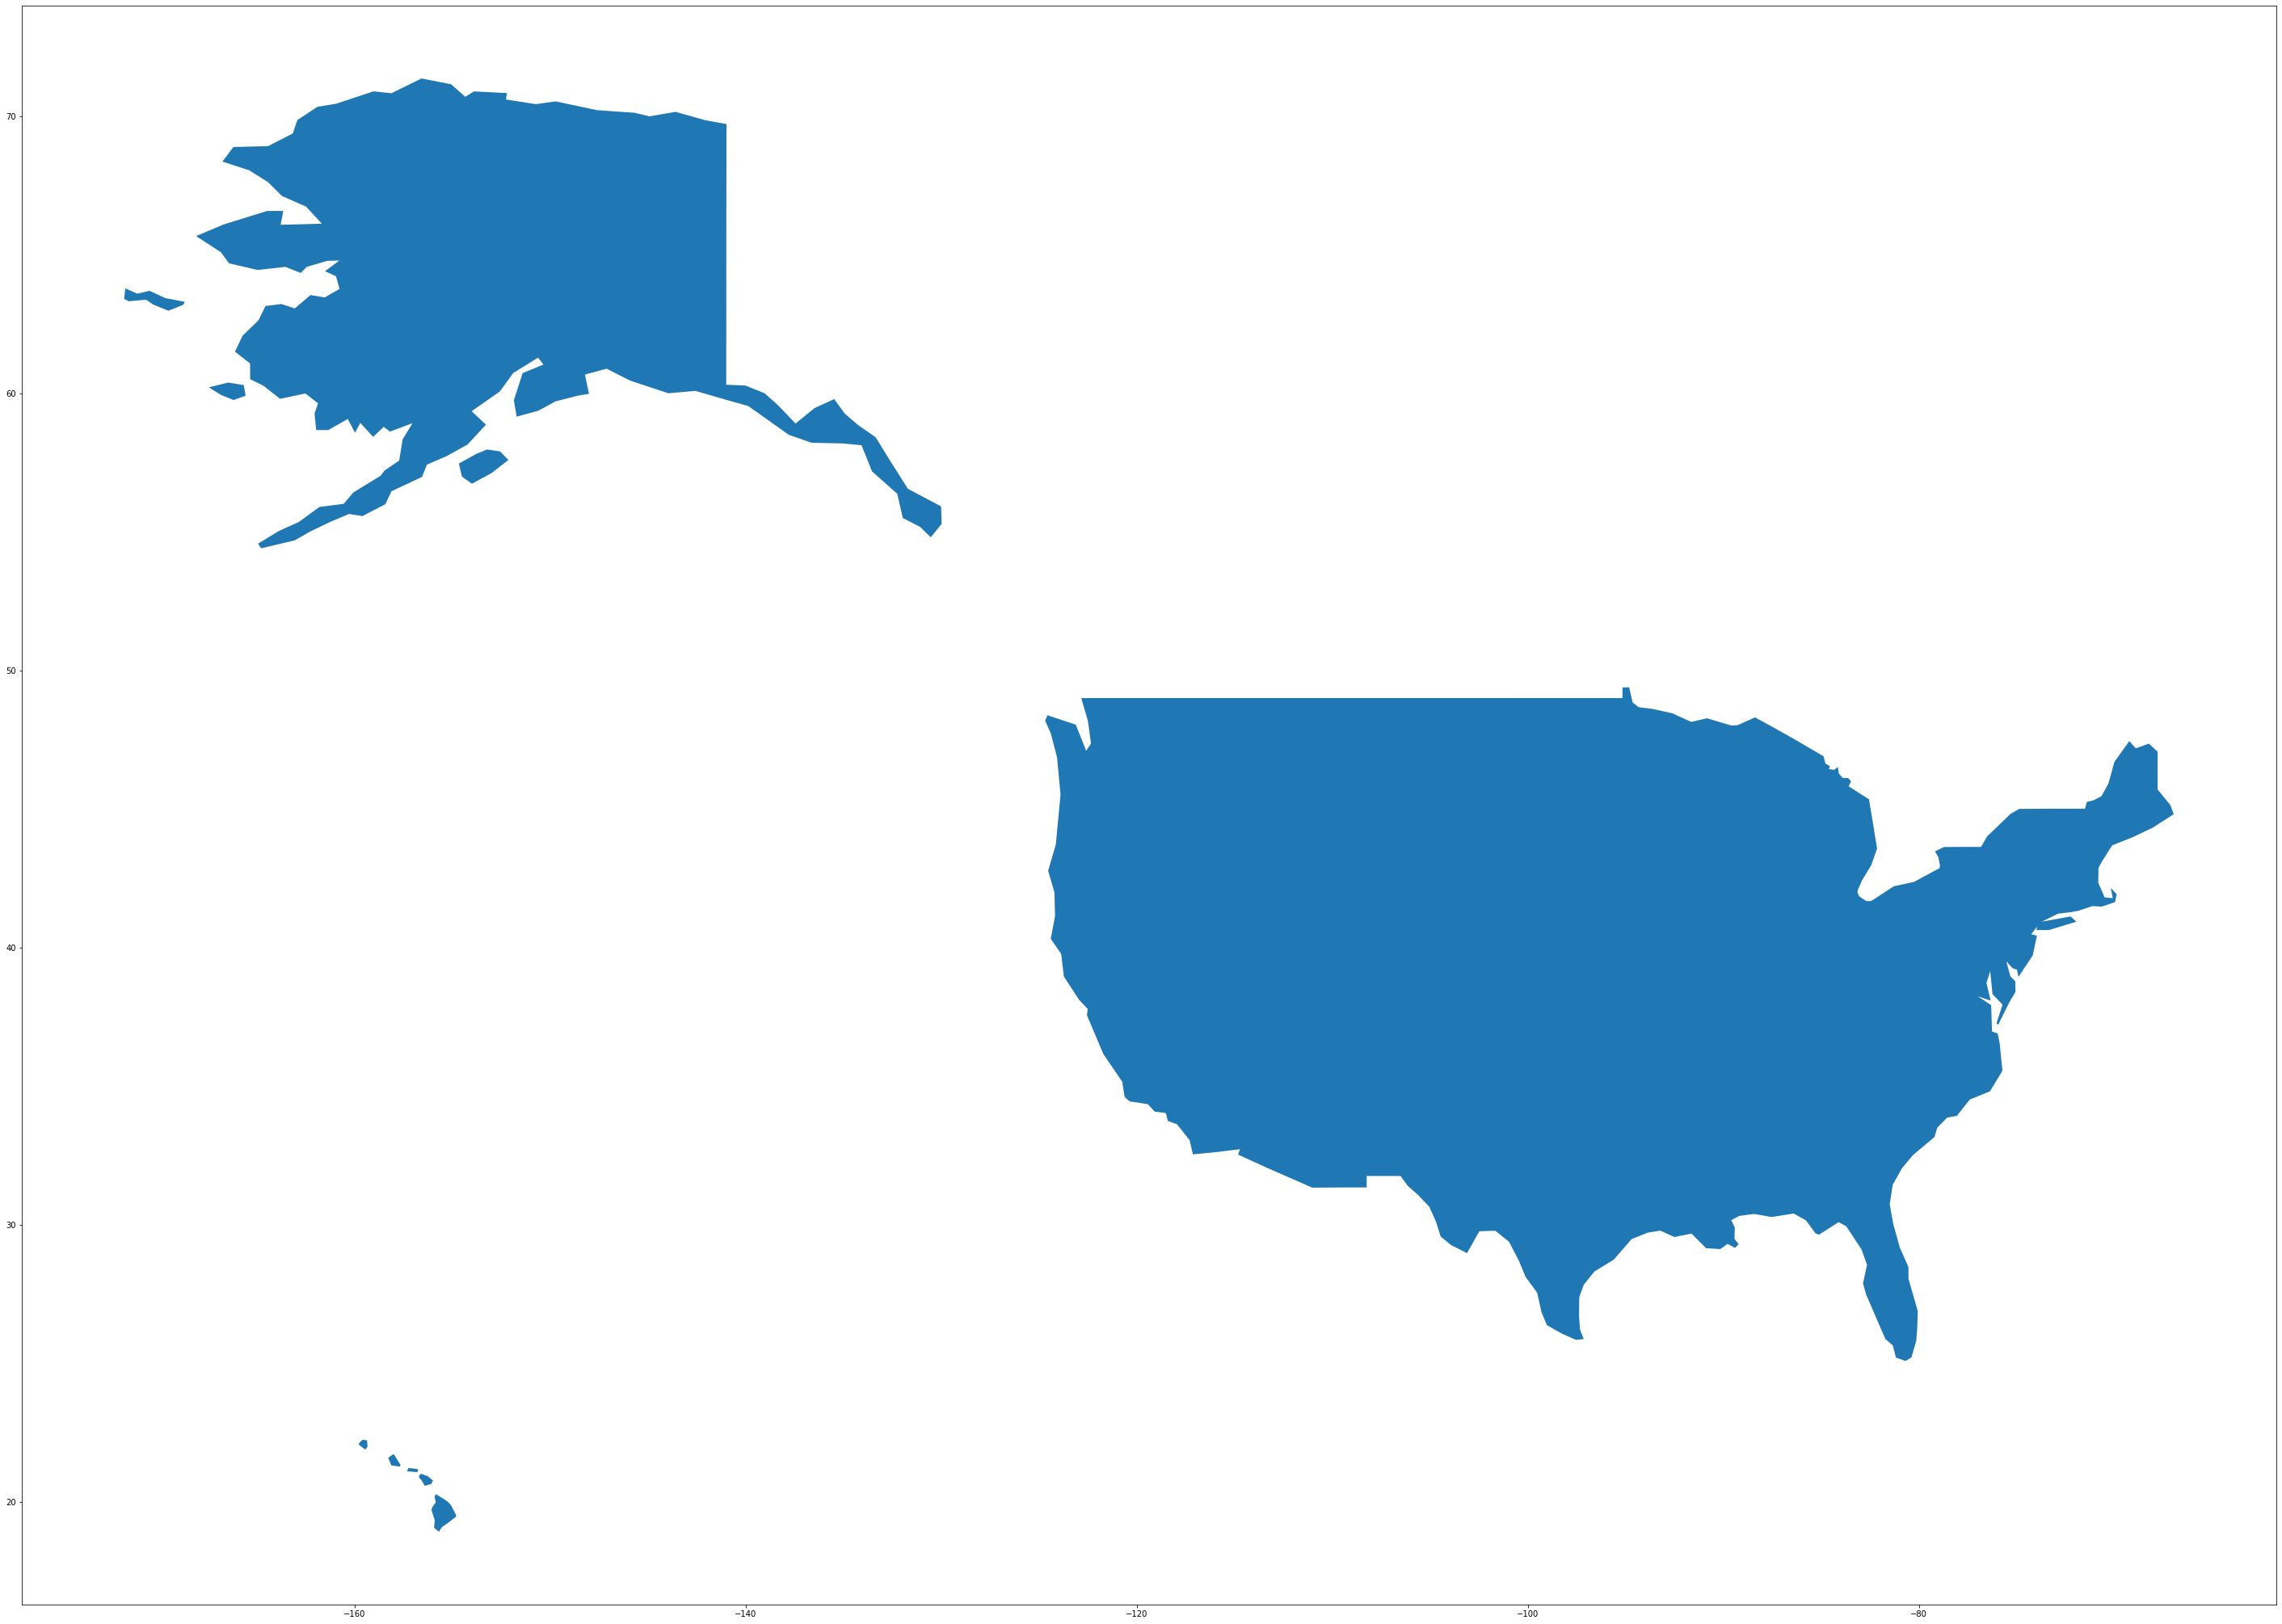

In [ ]:
#base layer 
gdfusa = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdfusa = gdfusa[gdfusa.continent == 'North America']
gdfusausa = gdfusa[gdfusa.name == 'United States of America']
fig,ax =plt.subplots(figsize = (50,50))
gdfusausa.plot(ax=ax)

In [ ]:
#turning newspapers_loc into geodataframe to read point values 
newspapers_loc['geometry'] = newspapers_loc['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(newspapers_loc, crs='epsg:4326')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


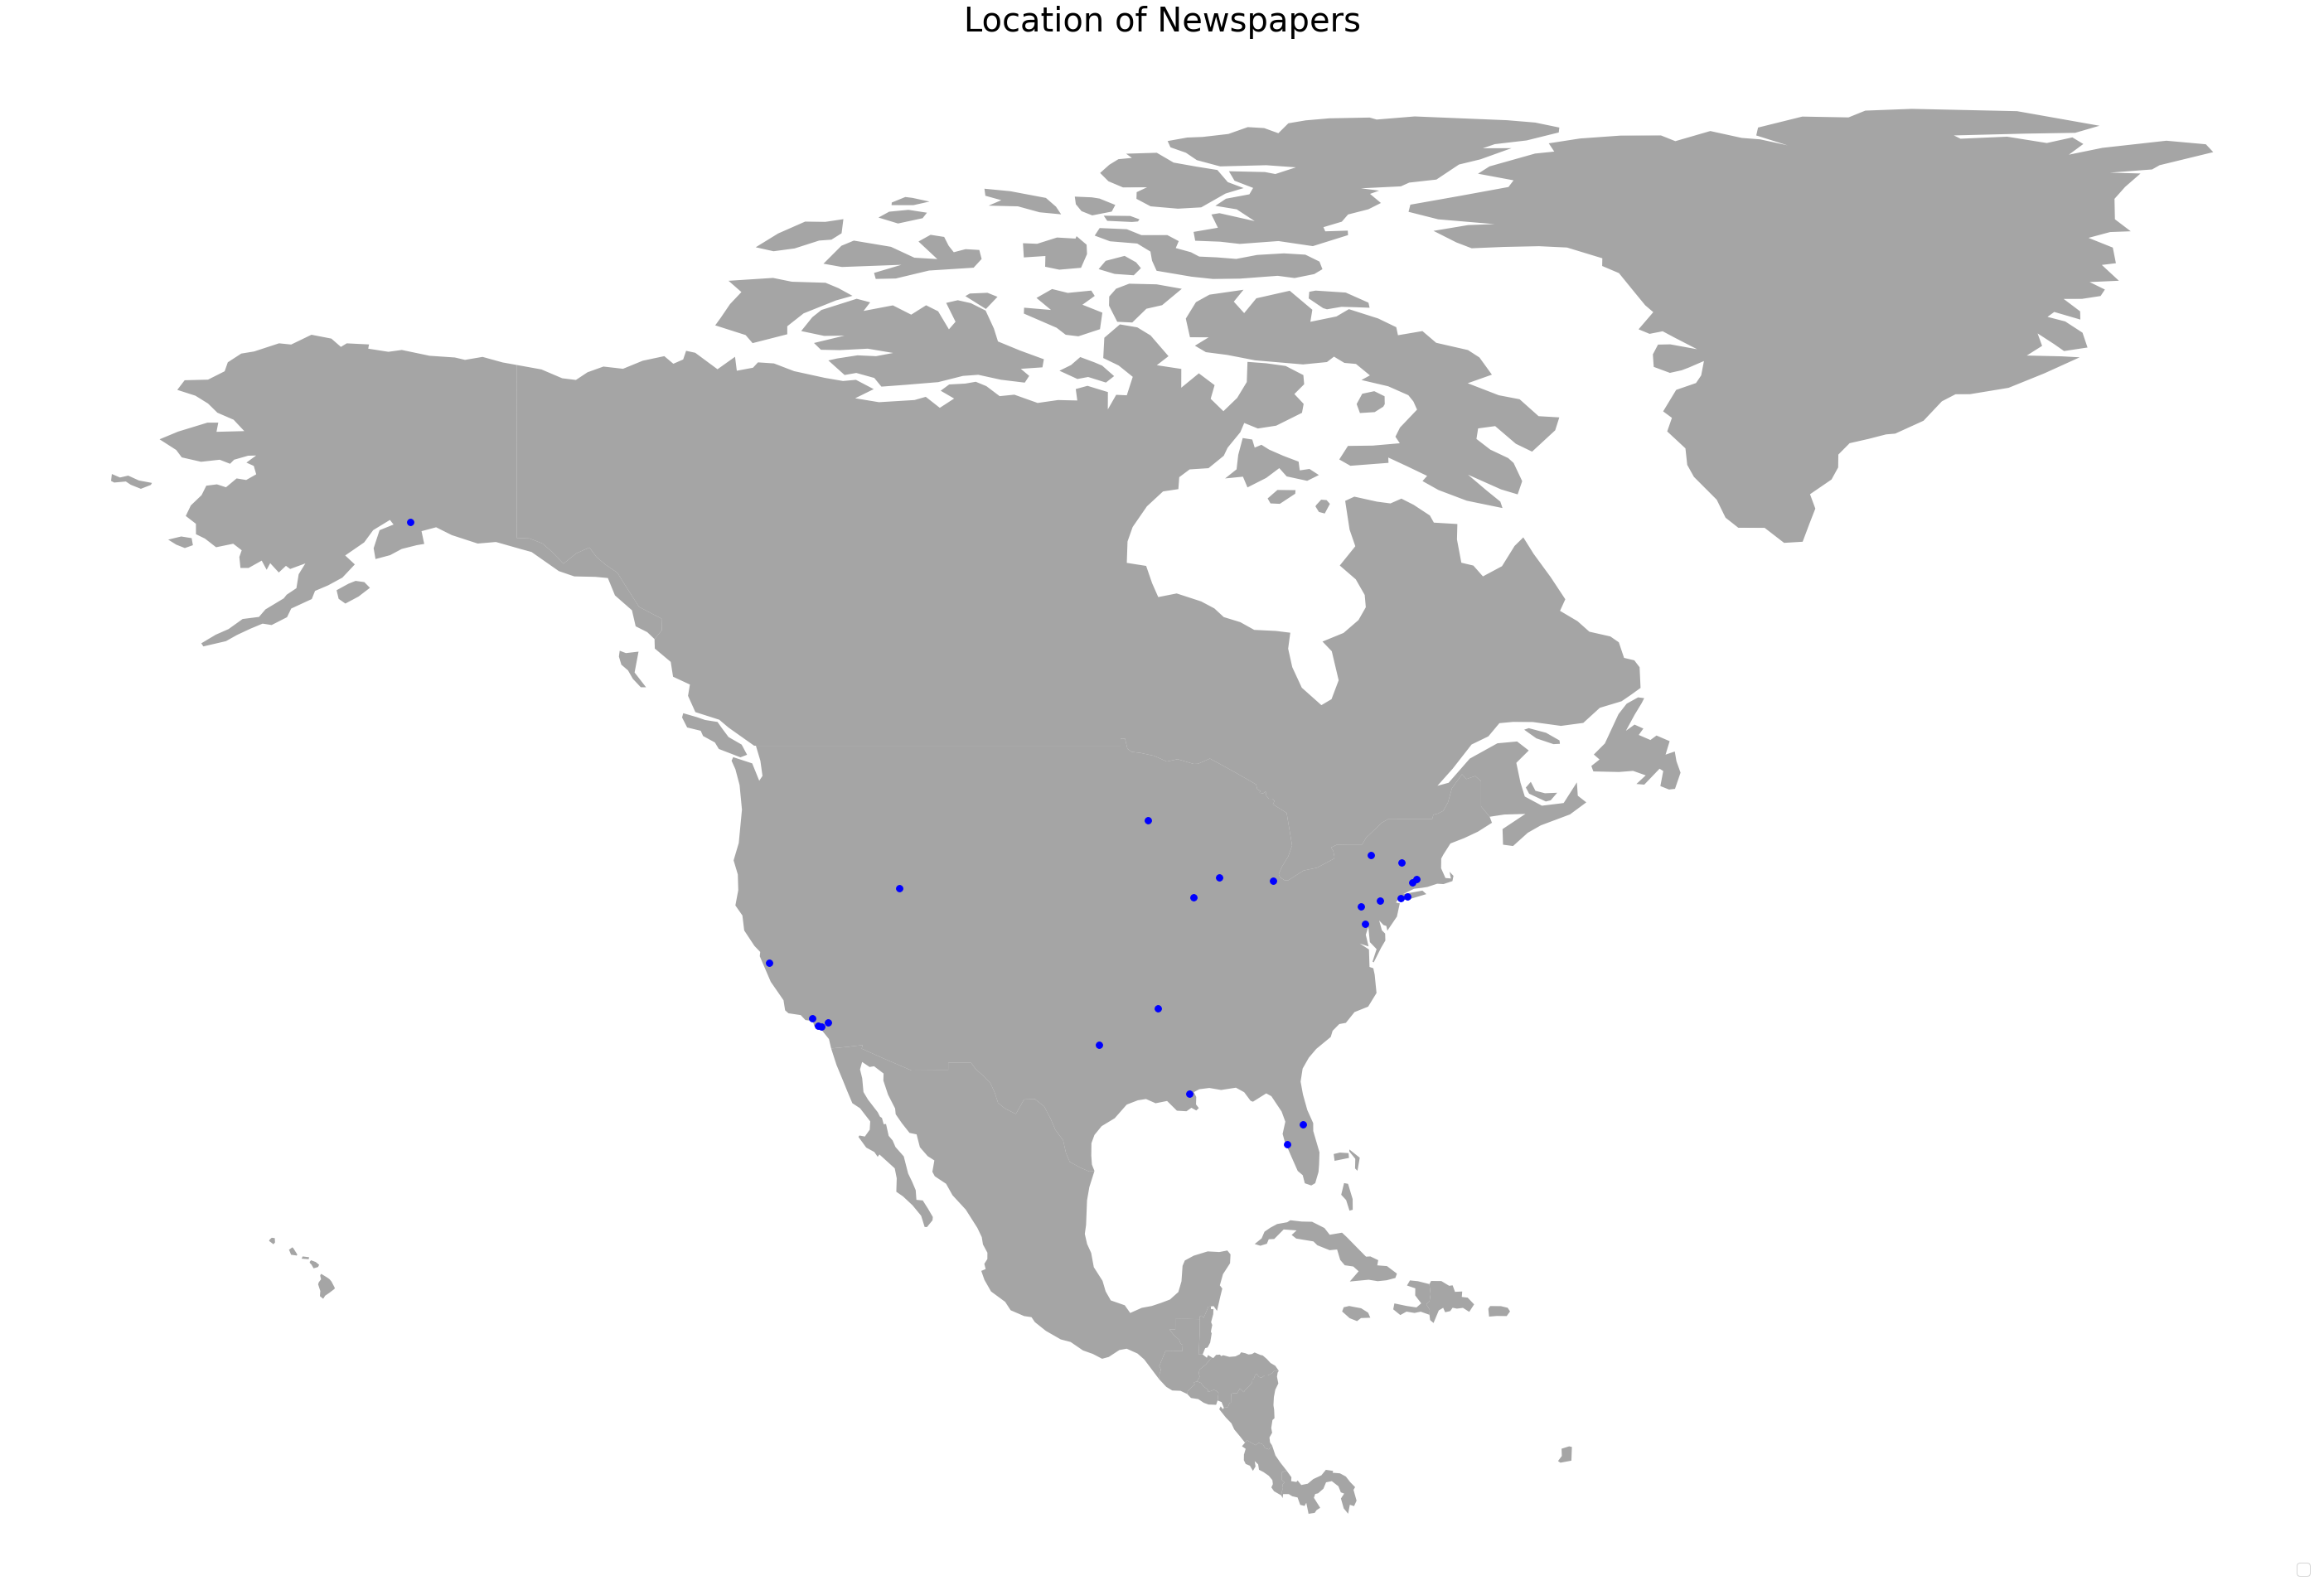

In [ ]:
fig,ax = plt.subplots(figsize = (50,50))
gdfusa.plot(ax=ax, alpha = 0.7, color="grey")
gdf.plot(ax = ax, markersize = 60, color = "blue", marker = "o")

plt.axis('off')
plt.title ("Location of Newspapers", fontsize = 40)
plt.savefig("paper_locations_geo.pdf",bbox_inches='tight')
plt. legend (prop={'size': 20}, loc = 'lower right')

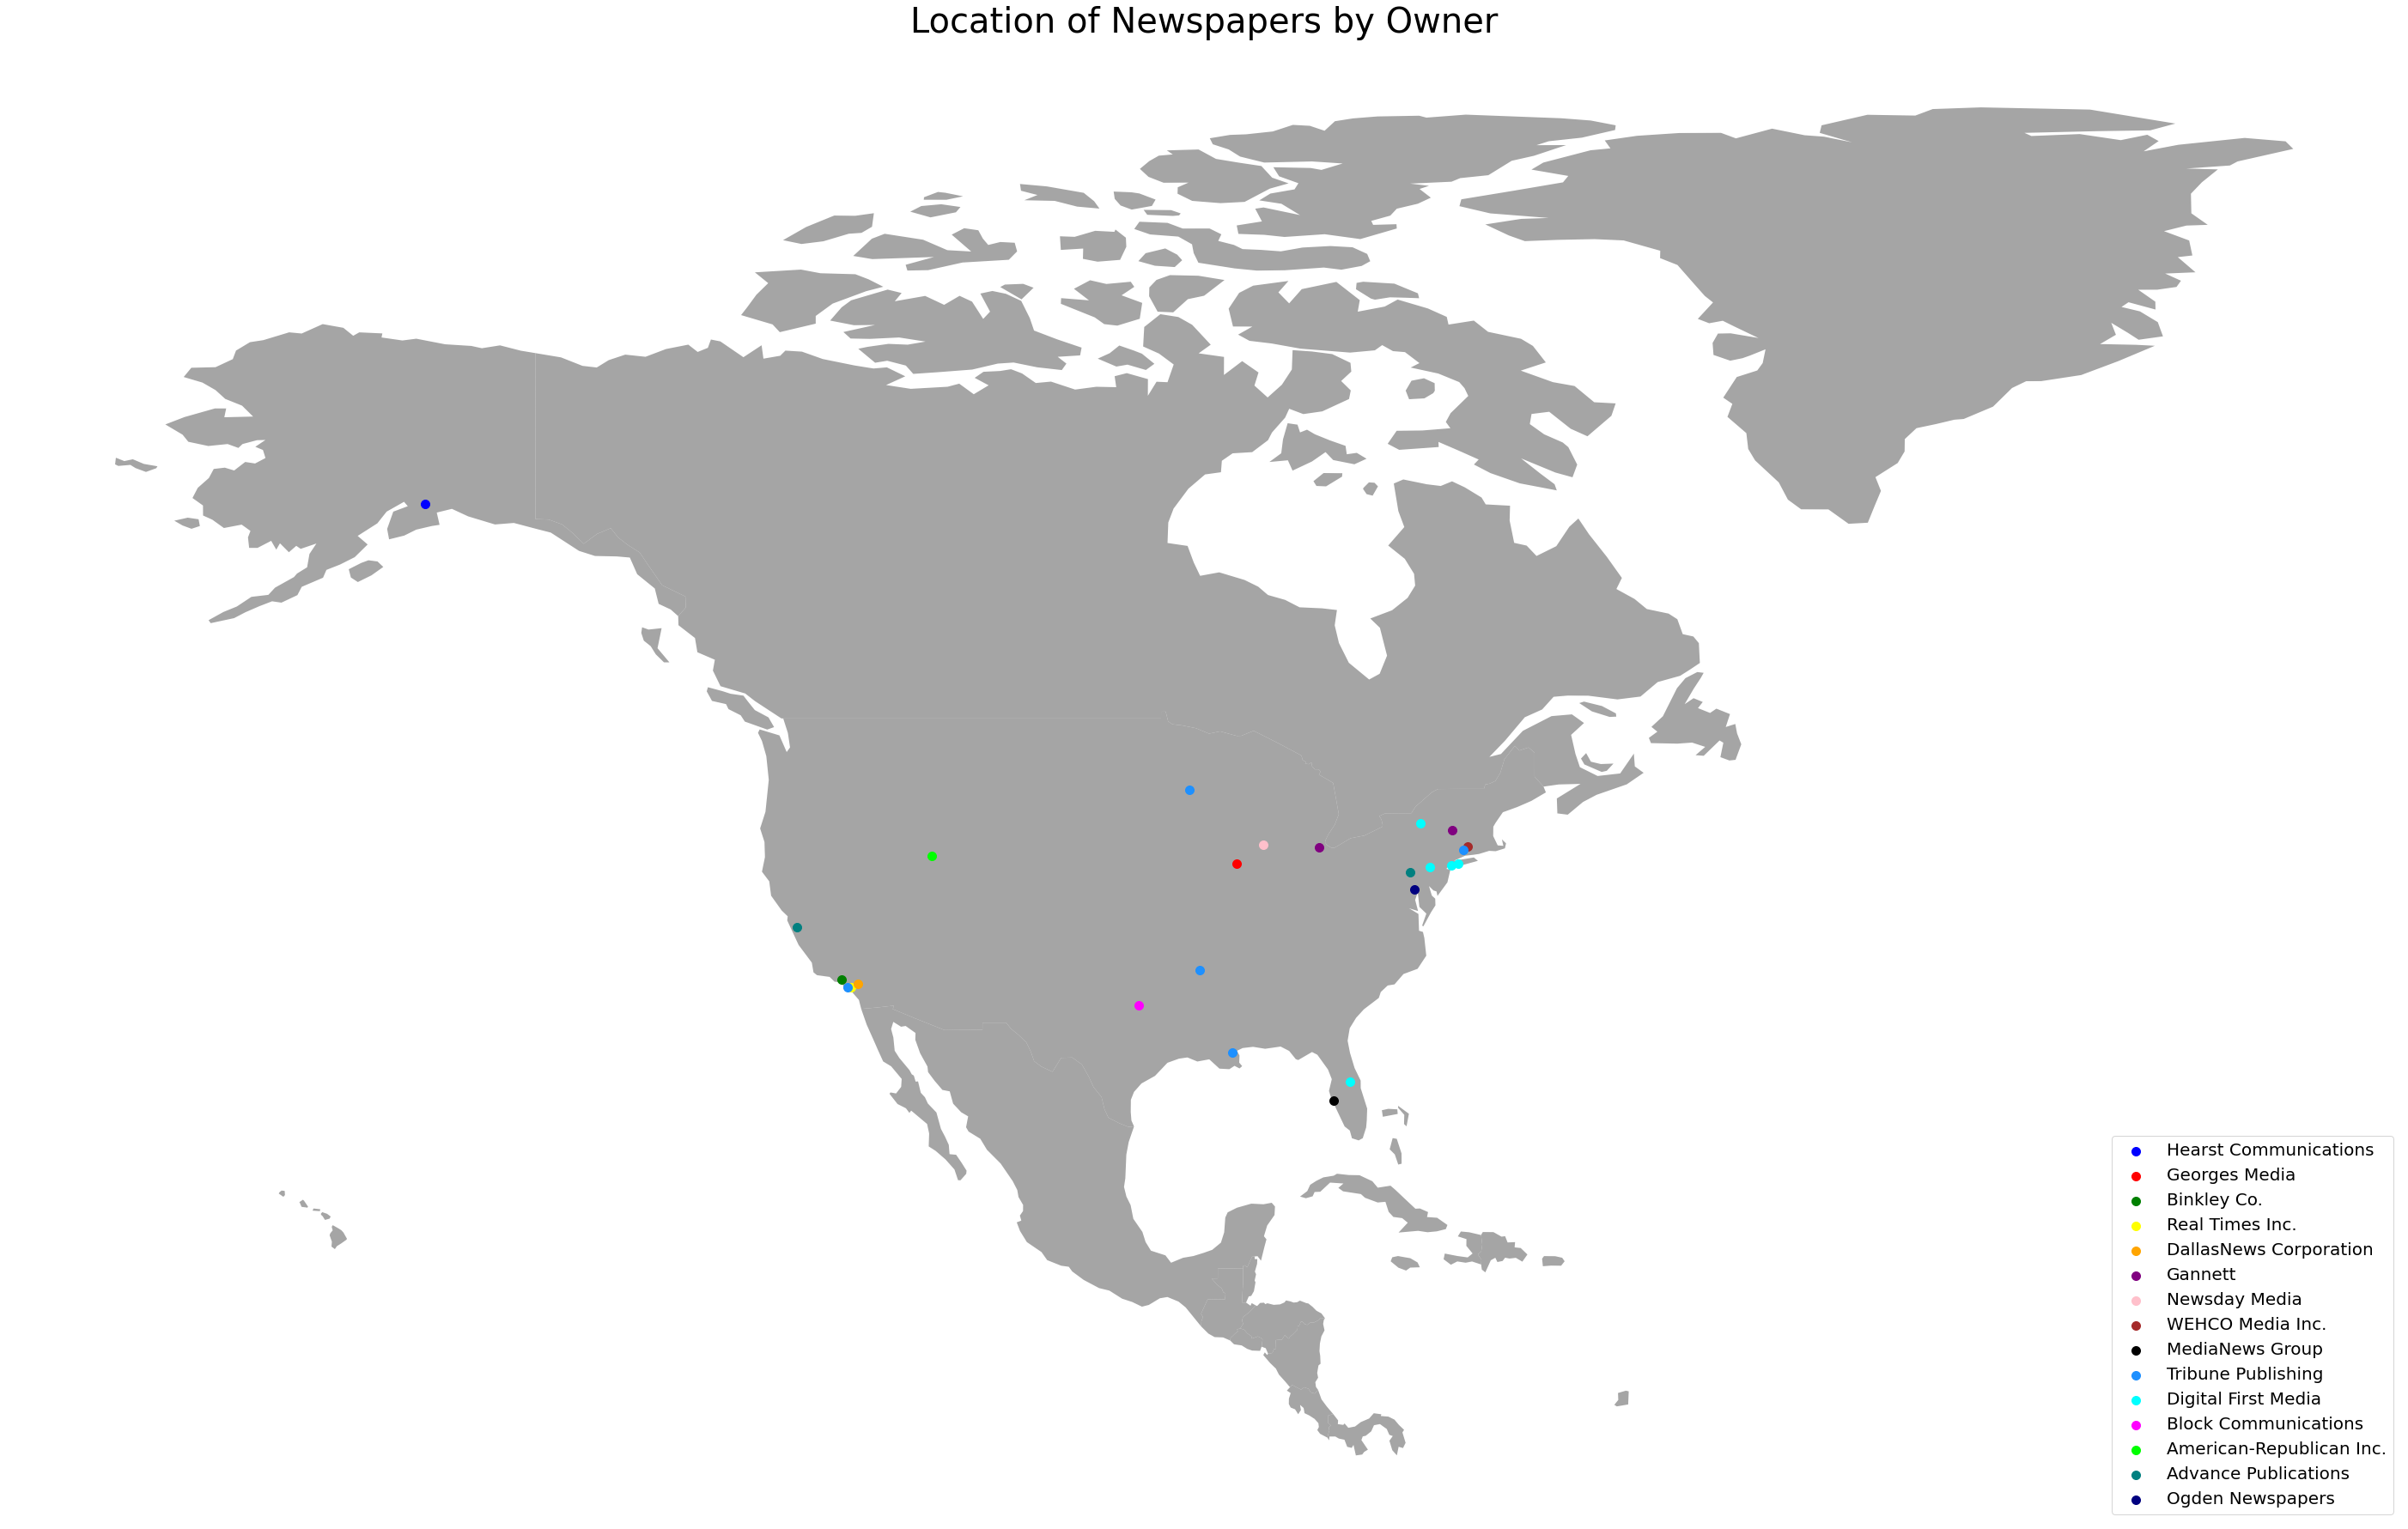

In [ ]:
#plotting so each owner has a different color
fig,ax = plt.subplots(figsize = (50,50))
gdfusa.plot(ax=ax, alpha = 0.7, color="grey")
#gdf.plot(ax = ax, markersize = 60, color = "blue", marker = "o")
#plotting newspaper location so that each owner is a different color
colors = ['blue', 'red', 'green', 'yellow', 'orange', 'purple', 'pink', 'brown', 'black', 'dodgerblue', 'cyan', 'magenta', 'lime', 'teal', 'navy', 'maroon']
for i in range(len(owners)):
    gdf[gdf[owners[i]] == 1].plot(ax=ax, markersize=100, color=colors[i], label=owners[i], marker='o')

plt.axis('off')
plt.title ("Location of Newspapers by Owner", fontsize = 40)
plt.savefig("paper_locations_geo_byowner.pdf",bbox_inches='tight')
plt.legend(prop={'size':20}, loc = 'lower right')

Building a model to predict depression based on NLP of news

In [ ]:
#merging NLP data of newspapers with city health data
news_local  = pd.read_parquet('data/news_local_cleaned.parquet')
city_health = pd.read_parquet('data/city_health_data_imp.parquet')

NLP_health = pd.merge(city_health, news_local, left_on=['url'], right_on=['domain']).reset_index()

In [ ]:
print(len(NLP_health))
NLP_health.columns

207169


Index(['level_0', 'index', 'State', 'City', 'Title', 'url_x', 'owner1',
       'owner2', 'degree_centrality_o1', 'degree_centrality_o2', 'degree_comp',
       'arthritis', 'high_blood_pressure', 'mammography', 'colonoscopy_test',
       'poor_health_status', 'all_teeth_lost', 'routine_checkup', 'depression',
       'sleep_<7hours', 'cervical_cancer_screening', 'smoking', 'obesity',
       'cancer', 'older_men_preventive_services', 'kidney_disease', 'diabetes',
       'medicine_high_blood_pressure', 'asthma', 'high_cholesterol',
       'binge_drinking', 'no_physical_activity', 'no_health_insurance',
       'dentist', 'stroke', 'bad_mental_health', 'pulmonary_disease',
       'older_women_preventive_services', 'bad_physical_health',
       'heart_disease', 'cholesterol_screening', 'det_arthritis',
       'det_high_blood_pressure', 'det_mammography', 'det_colonoscopy_test',
       'det_poor_health_status', 'det_all_teeth_lost', 'det_routine_checkup',
       'det_depression', 'det_sleep_<7

In [ ]:
#only grabbing variables that are needed
vars = ['State', 'City','domain', 'clean_bigrams', 'bigrams',
        'owner1','degree_centrality_o1',
        'det_poor_health_status','det_depression',
        'det_bad_mental_health','det_bad_physical_health',
        'health_count','top_words', 'sentiment', 'topics']

'''add topics after done running'''
#selecting only variables
NLP_health = NLP_health[vars]

In [ ]:
#One hot encoding cat variables 
def get_one_hot(df, var):
    var_dum = pd.get_dummies(df[var], prefix=var)
    df = pd.concat([df, var_dum], axis=1)
    df.drop([var], axis=1, inplace=True)
    return df
    
NLP_health = get_one_hot(NLP_health, "owner1")
NLP_health = get_one_hot(NLP_health, "topics")

In [ ]:
print(list(NLP_health.columns))

['State', 'City', 'domain', 'clean_bigrams', 'bigrams', 'degree_centrality_o1', 'det_poor_health_status', 'det_depression', 'det_bad_mental_health', 'det_bad_physical_health', 'health_count', 'top_words', 'sentiment', 'owner1_Advance Publications', 'owner1_American-Republican Inc.', 'owner1_Binkley Co.', 'owner1_Block Communications', 'owner1_DallasNews Corporation', 'owner1_Digital First Media', 'owner1_Gannett', 'owner1_Georges Media', 'owner1_Hearst Communications', 'owner1_MediaNews Group', 'owner1_Newsday Media', 'owner1_Ogden Newspapers', 'owner1_Real Times Inc.', 'owner1_Tribune Publishing', 'owner1_WEHCO Media Inc.', 'topics_0', 'topics_1', 'topics_2', 'topics_3', 'topics_4', 'topics_5', 'topics_6', 'topics_7', 'topics_8', 'topics_9', 'topics_10', 'topics_11', 'topics_12', 'topics_13', 'topics_14', 'topics_15']


In [ ]:

#adding one hot of top_words and bigrams
def get_top_tokens(tokens_column, n=10):
    all_top_words = [item for sublist in tokens_column for item in sublist]
    all_top_words = Counter(all_top_words)
    all_top_words = {k: v for k, v in sorted(all_top_words.items(), key=lambda item: item[1], reverse=True)}

    per_98 = round(np.percentile(list(all_top_words.values()), 98, axis=None, out=None))
    #per_99 = round(np.percentile(list(all_top_words.values()), 99, axis=None, out=None))
    
    top_words = {k:v for k,v in all_top_words.items() if v<per_98}
    top_words = list(top_words.keys())[0:10]
    
    return top_words

def get_top_df(top_words, df, empty_top_df, var):
    for word in top_words:
        for i in range(len(empty_top_df)):
            empty_top_df.iloc[i][word] = int(word in df.iloc[i][var])
    return empty_top_df

#looking in all tokens from text, including bigrams from whole corpus
all_top_words = get_top_tokens(NLP_health['clean_bigrams'])
empty_top_df = pd.DataFrame(np.nan, index=NLP_health.index, columns=all_top_words)
top_df_words = get_top_df(all_top_words, NLP_health, empty_top_df, 'clean_bigrams')

#adding just the bigrams by article based on mutual information
all_top_bigrams = get_top_tokens(NLP_health['bigrams'])
empty_top_df = pd.DataFrame(np.nan, index=NLP_health.index, columns=all_top_bigrams)
top_df_bigrams = get_top_df(all_top_bigrams, NLP_health, empty_top_df, 'bigrams')


In [ ]:
print(all_top_words)
print(all_top_bigrams)

['oversized', 'powerless', 'centralized', 'coincidentally', 'stimulation', '395', 'finn', 'thefts', 'roam', 'syringes']
['already_affecting', 'back_bargaining', 'access_television', 'address_mental', 'take_long', 'gas_line', 'court_case', 'afternoon_meeting', 'commercial_fisherman', 'article_section']


In [ ]:
NLP_health1 = pd.concat([NLP_health, top_df_words], axis=1, ignore_index=False)
training_data = pd.concat([NLP_health1, top_df_bigrams], axis=1, ignore_index=False)

Creating Artificial Neural Net

In [ ]:
#splitting into train and test
X = training_data.iloc[:,5:]
#dropping health variables to avoid multicollinearity with depression
X.drop(['det_poor_health_status','det_depression',
        'det_bad_mental_health','det_bad_physical_health', 'top_words'], axis=1, inplace=True)

Y = training_data['det_depression']

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=8)

#scaling features with standardization
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
print(list(X_train.columns))

['degree_centrality_o1', 'health_count', 'sentiment', 'owner1_Advance Publications', 'owner1_American-Republican Inc.', 'owner1_Binkley Co.', 'owner1_Block Communications', 'owner1_DallasNews Corporation', 'owner1_Digital First Media', 'owner1_Gannett', 'owner1_Georges Media', 'owner1_Hearst Communications', 'owner1_MediaNews Group', 'owner1_Newsday Media', 'owner1_Ogden Newspapers', 'owner1_Real Times Inc.', 'owner1_Tribune Publishing', 'owner1_WEHCO Media Inc.', 'topics_0', 'topics_1', 'topics_2', 'topics_3', 'topics_4', 'topics_5', 'topics_6', 'topics_7', 'topics_8', 'topics_9', 'topics_10', 'topics_11', 'topics_12', 'topics_13', 'topics_14', 'topics_15', 'oversized', 'powerless', 'centralized', 'coincidentally', 'stimulation', '395', 'finn', 'thefts', 'roam', 'syringes', 'already_affecting', 'back_bargaining', 'access_television', 'address_mental', 'take_long', 'gas_line', 'court_case', 'afternoon_meeting', 'commercial_fisherman', 'article_section']


In [ ]:
def baseline_model():
	# create model
	model = tf.keras.models.Sequential()
	model.add(tf.keras.layers.Dense(6, kernel_initializer='normal', activation='relu'))
	model.add(tf.keras.layers.Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model

estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=30, verbose=0)

#cross validation 5 splits
#using RMSE as evaluation metric
kfold = KFold(n_splits=5)
results = cross_val_score(estimator, X_train, Y_train, cv=kfold, scoring='neg_root_mean_squared_error')
print("Baseline: %.2f (%.2f) RMSE" % (results.mean(), results.std()))

/var/folders/fc/vhrg50qd74x2j3j9gbnl92140000gn/T/ipykernel_26984/2544510085.py:9: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=30, verbose=0)


Baseline: -3.34 (0.02) RMSE


In [ ]:
#creating deeper network
def deeper_model():
    # create model 3 hidden layers
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(tf.keras.layers.Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(tf.keras.layers.Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(tf.keras.layers.Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
estimator = KerasRegressor(build_fn=deeper_model, epochs=50, batch_size=30, verbose=0)
#cross validation 5 splits

results = cross_val_score(estimator, X_train, Y_train, cv=kfold, scoring='neg_root_mean_squared_error')
print("Deep: %.2f (%.2f) RMSE" % (results.mean(), results.std()))

/var/folders/fc/vhrg50qd74x2j3j9gbnl92140000gn/T/ipykernel_26984/2442593221.py:12: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=deeper_model, epochs=50, batch_size=30, verbose=0)


Deep: -3.33 (0.02) RMSE


In [ ]:
#creating wider network
def wider_model():
    #create 1 wide layer
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(20, kernel_initializer='normal', activation='relu'))
    model.add(tf.keras.layers.Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

estimator = KerasRegressor(build_fn=deeper_model, epochs=50, batch_size=30, verbose=0)
#cross validation 5 splits
results = cross_val_score(estimator, X_train, Y_train, cv=kfold, scoring='neg_root_mean_squared_error')
print("Wide: %.2f (%.2f) RMSE" % (results.mean(), results.std()))

/var/folders/fc/vhrg50qd74x2j3j9gbnl92140000gn/T/ipykernel_26984/1900655231.py:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=deeper_model, epochs=50, batch_size=30, verbose=0)


Wide: -3.48 (0.32) RMSE


In [ ]:
#creating deeper network
def thin_model():
    # create model 3 hidden layers
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(4, kernel_initializer='normal', activation='relu'))
    model.add(tf.keras.layers.Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
estimator = KerasRegressor(build_fn=thin_model, epochs=50, batch_size=30, verbose=0)
#cross validation 5 splits
results = cross_val_score(estimator, X_train, Y_train, cv=kfold, scoring='neg_root_mean_squared_error')
print("Deep: %.2f (%.2f) RMSE" % (results.mean(), results.std()))

/var/folders/fc/vhrg50qd74x2j3j9gbnl92140000gn/T/ipykernel_26984/3412645289.py:10: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=thin_model, epochs=50, batch_size=30, verbose=0)


Deep: -3.35 (0.02) RMSE


In [ ]:
#deeper net does best

#creating deeper network
def best_model():
    # create model 5 hidden layers
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(tf.keras.layers.Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(tf.keras.layers.Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(tf.keras.layers.Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(tf.keras.layers.Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(tf.keras.layers.Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
estimator = KerasRegressor(build_fn=best_model, epochs=50, batch_size=30, verbose=0)
#cross validation 5 splits
results = cross_val_score(estimator, X_train, Y_train, cv=kfold, scoring='neg_root_mean_squared_error')
print("Deep: %.2f (%.2f) RMSE" % (results.mean(), results.std()))

/var/folders/fc/vhrg50qd74x2j3j9gbnl92140000gn/T/ipykernel_26984/502054037.py:16: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=best_model, epochs=50, batch_size=30, verbose=0)


Deep: -3.33 (0.01) RMSE


In [91]:
#comparing to metrics on depression
Y.describe()
#our model not only has low RMSE but also a RMSE lower than std of depression, meaning it is not merely predicting randomly on variable with low variance

count    207169.000000
mean         21.303158
std           4.119635
min          15.700000
25%          16.100000
50%          21.600000
75%          25.000000
max          29.400000
Name: det_depression, dtype: float64

In [109]:
#creating visualization of network
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(6, kernel_initializer='normal', activation='relu'))
model.add(tf.keras.layers.Dense(6, kernel_initializer='normal', activation='relu'))
model.add(tf.keras.layers.Dense(6, kernel_initializer='normal', activation='relu'))
model.add(tf.keras.layers.Dense(6, kernel_initializer='normal', activation='relu'))
model.add(tf.keras.layers.Dense(6, kernel_initializer='normal', activation='relu'))
model.add(tf.keras.layers.Dense(1, kernel_initializer='normal'))
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, Y_train, epochs=50, batch_size=30, verbose=0)
from ann_visualizer.visualize import ann_viz
ann_viz(model)

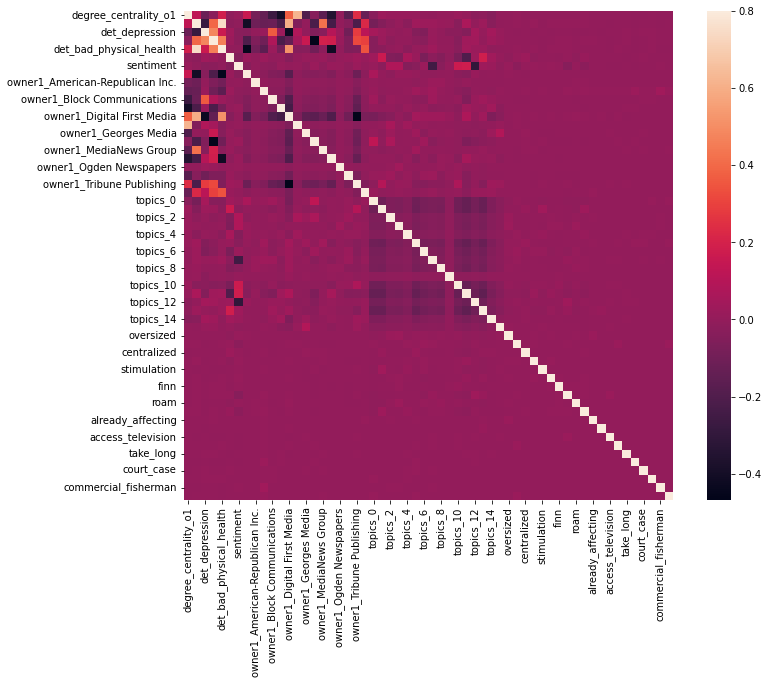

In [88]:
#checking if ann does better without all features
values = training_data.iloc[:,5:]
#correlation matrix
corrmat = training_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
#plt.savefig('corr_matrix.pdf')

In [98]:
#trying neural network without word variables
#removing words and bigrams
X = training_data.iloc[:,5:44]
X.drop(['det_poor_health_status','det_depression',
        'det_bad_mental_health','det_bad_physical_health', 'top_words'], axis=1, inplace=True)

Y = training_data['det_depression']

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=8)

#scaling features with standardization
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=30, verbose=0)

#cross validation 5 splits
#using RMSE as evaluation metric
results = cross_val_score(estimator, X_train, Y_train, cv=kfold, scoring='neg_root_mean_squared_error')
print("Baseline: %.2f (%.2f) RMSE" % (results.mean(), results.std()))

/var/folders/fc/vhrg50qd74x2j3j9gbnl92140000gn/T/ipykernel_26984/1230699115.py:10: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=30, verbose=0)


Baseline: -3.33 (0.02) RMSE


In [99]:
#running on best model since it preformed better than net with all variables
estimator = KerasRegressor(build_fn=best_model, epochs=50, batch_size=30, verbose=0)
#cross validation 5 splits
results = cross_val_score(estimator, X_train, Y_train, cv=kfold, scoring='neg_root_mean_squared_error')
print("Baseline: %.2f (%.2f) RMSE" % (results.mean(), results.std()))

#original deep model is better 
#disregarding this as a direction

/var/folders/fc/vhrg50qd74x2j3j9gbnl92140000gn/T/ipykernel_26984/2212628036.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=best_model, epochs=50, batch_size=30, verbose=0)


Baseline: -3.33 (0.02) RMSE


Running model on Physical Health

In [100]:
X = training_data.iloc[:,5:]
X.drop(['det_poor_health_status','det_depression',
        'det_bad_mental_health','det_bad_physical_health', 'top_words'], axis=1, inplace=True)

Y = training_data['det_bad_physical_health']

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=8)

#scaling features with standardization
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [101]:
#baseline for physical health
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=30, verbose=0)

#cross validation 5 splits
#using RMSE as evaluation metric
results = cross_val_score(estimator, X_train, Y_train, cv=kfold, scoring='neg_root_mean_squared_error')
print("Baseline: %.2f (%.2f) RMSE" % (results.mean(), results.std()))

/var/folders/fc/vhrg50qd74x2j3j9gbnl92140000gn/T/ipykernel_26984/2733273011.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=30, verbose=0)


Baseline: -1.57 (0.01) RMSE


In [102]:
#deep for physical
estimator = KerasRegressor(build_fn=deeper_model, epochs=50, batch_size=30, verbose=0)
#cross validation 5 splits

results = cross_val_score(estimator, X_train, Y_train, cv=kfold, scoring='neg_root_mean_squared_error')
print("Deep: %.2f (%.2f) RMSE" % (results.mean(), results.std()))

/var/folders/fc/vhrg50qd74x2j3j9gbnl92140000gn/T/ipykernel_26984/342315769.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=deeper_model, epochs=50, batch_size=30, verbose=0)


Deep: -1.58 (0.01) RMSE


In [104]:
#wide for physical
estimator = KerasRegressor(build_fn=wider_model, epochs=50, batch_size=30, verbose=0)
#cross validation 5 splits
results = cross_val_score(estimator, X_train, Y_train, cv=kfold, scoring='neg_root_mean_squared_error')
print("Wide: %.2f (%.2f) RMSE" % (results.mean(), results.std()))

/var/folders/fc/vhrg50qd74x2j3j9gbnl92140000gn/T/ipykernel_26984/2979699881.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=wider_model, epochs=50, batch_size=30, verbose=0)


Wide: -1.58 (0.01) RMSE


In [111]:
Y.describe()

count    207169.000000
mean         14.474296
std           2.825804
min           6.500000
25%          13.600000
50%          14.900000
75%          15.667267
max          25.400000
Name: det_bad_physical_health, dtype: float64